# Imports / Set up

In [1]:
from __future__ import annotations

import os
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import ticker
from torch.utils.data import DataLoader
import matplotlib.colors as colors

from operator_aliasing.data.utils import get_data
from operator_aliasing.data.utils import get_dataset
from operator_aliasing.models.utils import get_model
from operator_aliasing.train.utils import load_latest_ckpt
from operator_aliasing.utils import get_energy_curve
from operator_aliasing.utils import get_energy_curve_1d
from operator_aliasing.utils import get_model_preds
from operator_aliasing.utils import get_dataset_info
from operator_aliasing.train.train import test_model
from matplotlib.colors import LogNorm, Normalize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

FIG_DIR = '../figures'

ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'


def str_from_res(resolutions=[0, 1, 0, 0]):
    resolutions = str(resolutions)
    resolutions = resolutions.replace('[', '')
    resolutions = resolutions.replace(']', '')
    resolutions = resolutions.replace(' ', '')
    resolutions = resolutions.replace(',', '_')
    resolutions = resolutions.replace('.', '')
    return resolutions

# dataset params
darcy_forcing_term = 1.0
burger_viscosity = 0.001
comp_ns_params = ['Turb', 1.0, 1e-08, 1e-08, 'periodic', 512]
seed = 0   

device=device(type='cuda')


# Aliasing Overview
TODO: redo w/ newly trained model

3 rows (1st: sample img, 2nd, avg label+avg model pred spectrum, 3rd avg residual spectrum)
- 2nd and 3rd row can be smaller than the first one

0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000


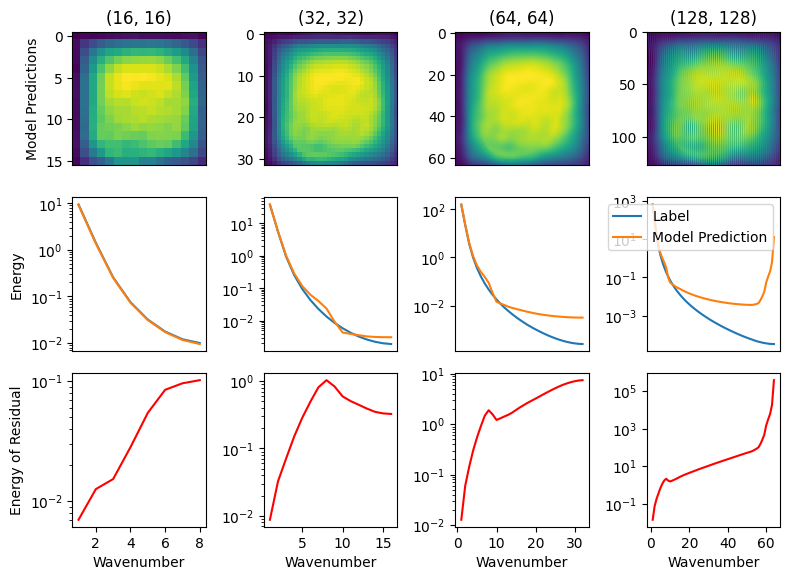

In [22]:
fig, axs = plt.subplots(3, 4, figsize=(8, 6))


# get data args
loss = 'mse'
dataset_name = 'darcy_pdebench'
darcy_forcing_term = 1.0
burger_viscosity = 'na'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, loss)
max_mode = 8
# grab trained model
model = get_model(
    model_name=model_name,
    max_modes=max_mode,
    hidden_channels=32,
    in_channels=in_channels,
    out_channels=out_channels,
)

#ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{img_size}_{max_mode}_{model_name}_{in_channels}_{initial_steps}'
resolutions = str_from_res([0,0,0,1])
ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
ckpt_dir = str(ckpt_dir).replace('.', '')
print(ckpt_dir)
ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
ckpt_dict = load_latest_ckpt(ckpt_pth)
model.load_state_dict(ckpt_dict['model_state_dict'])
model = model.to(device)
model = model.eval()

for x_idx, res in enumerate([16, 32, 64, 128]):
    resolution_ratio = [0, 0, 0, 0]
    resolution_ratio[-(x_idx+1)] = 1
    resolutions = [16, 32, 64, 128]# [128, 64, 32, 16]
    dataset = get_dataset(
        dataset_name=dataset_name,
        filter_lim=-1,
        img_size=res,
        downsample_dim=-1,
        train=False,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
        batch_size=128,
        seed=0,
        resolution_ratios=resolution_ratio,
    )
    # sample = dataset[0]
    sample = {
        'x': torch.concat([dataset[i]['x'] for i in range(len(dataset))]),
        'y': torch.concat([dataset[i]['y'] for i in range(len(dataset))]),
    }
    # grab a single input from the last batch
    model_input = sample['x'].to(device)  # .unsqueeze(dim=0).to(device)
    with torch.no_grad():
        model_output = model(x=model_input)
    ground_truth = sample['y']  # .unsqueeze(dim=0)
    residuals = model_output - ground_truth.to(
        device
    )  # / ground_truth.to(device)

    # convert to plotable form
    model_in = model_input[0, 0, :, :].cpu().numpy()
    output = model_output[0, 0, :, :].cpu().numpy()
    label = ground_truth[0, 0, :, :].cpu().numpy()

    axs[0, x_idx].imshow(output)
    #axs[3, x_idx].imshow(output-label)
    axs[0, x_idx].set_title(f'{(resolutions[x_idx], resolutions[x_idx])}')
    # axs[0, x_idx].get_yaxis().set_visible(False)
    axs[0, x_idx].get_xaxis().set_visible(False)
    axs[1, x_idx].get_xaxis().set_visible(False)

    label_spectrum = get_energy_curve(ground_truth)
    pred_spectrum = get_energy_curve(model_output)
    residual_spectrum = get_energy_curve(residuals)

    axs[1, x_idx].set_yscale('log')
    x = np.linspace(1, len(label_spectrum), len(label_spectrum))
    axs[1, x_idx].plot(x, label_spectrum, label='Label')
    axs[1, x_idx].plot(x, pred_spectrum, label='Model Prediction')

    axs[2, x_idx].set_yscale('log')
    axs[2, x_idx].plot(
        x, residual_spectrum / label_spectrum, label='Resid', color='red'
    )
    axs[2, x_idx].set_xlabel('Wavenumber')
    # plt.locator_params(axis="x", integer=True, tight=True)
    axs[2, x_idx].xaxis.set_major_locator(
        ticker.MaxNLocator(integer=True, nbins=4)
    )
    if x_idx == 0:
        axs[2, x_idx].set_ylabel('Energy of Residual')
        axs[1, x_idx].set_ylabel('Energy')
        axs[0, x_idx].set_ylabel('Model Predictions')
        #axs[3, x_idx].set_ylabel('Residual')

axs[1, x_idx].legend(loc='upper right')
plt.tight_layout()
fig.savefig(
    f'{FIG_DIR}/aliasing_overview.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000


/tmp/ipykernel_1691912/3085085766.py:119: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


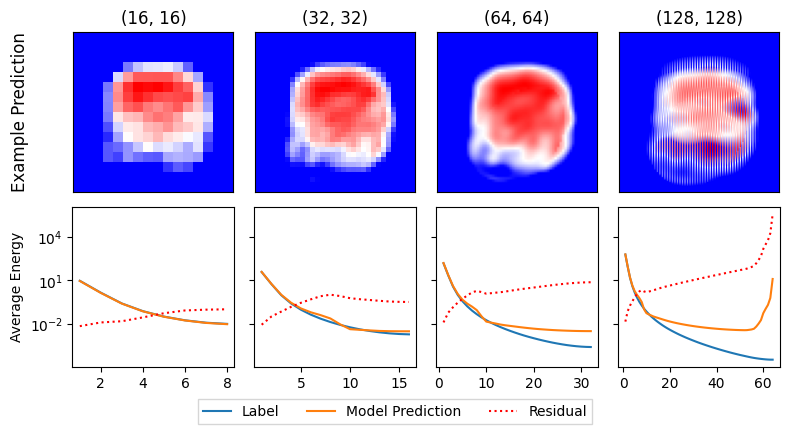

In [89]:
#fig, axs = plt.subplots(3, 4, figsize=(8, 8))

fig = plt.figure(layout='constrained', figsize=(8, 3.5))
subfigs = fig.subfigures(2, 1, wspace=0.07) # three rows

img_axs = subfigs[0].subplots(1, 4, sharey=False)
spectrum_axs = subfigs[1].subplots(1, 4, sharey='row')
#residual_axs = subfigs[2].subplots(1, 4, sharey='row')

# get data args
loss = 'mse'
dataset_name = 'darcy_pdebench'
darcy_forcing_term = 1.0
burger_viscosity = 'na'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, loss)
max_mode = 8
# grab trained model
model = get_model(
    model_name=model_name,
    max_modes=max_mode,
    hidden_channels=32,
    in_channels=in_channels,
    out_channels=out_channels,
)

#ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{img_size}_{max_mode}_{model_name}_{in_channels}_{initial_steps}'
resolutions = str_from_res([0,0,0,1])
ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
ckpt_dir = str(ckpt_dir).replace('.', '')
print(ckpt_dir)
ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
ckpt_dict = load_latest_ckpt(ckpt_pth)
model.load_state_dict(ckpt_dict['model_state_dict'])
model = model.to(device)
model = model.eval()

for x_idx, res in enumerate([16, 32, 64, 128]):
    resolution_ratio = [0, 0, 0, 0]
    resolution_ratio[-(x_idx+1)] = 1
    resolutions = [16, 32, 64, 128]# [128, 64, 32, 16]
    dataset = get_dataset(
        dataset_name=dataset_name,
        filter_lim=-1,
        img_size=res,
        downsample_dim=-1,
        train=False,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
        batch_size=128,
        seed=0,
        resolution_ratios=resolution_ratio,
    )
    # sample = dataset[0]
    sample = {
        'x': torch.concat([dataset[i]['x'] for i in range(len(dataset))]),
        'y': torch.concat([dataset[i]['y'] for i in range(len(dataset))]),
    }
    # grab a single input from the last batch
    model_input = sample['x'].to(device)  # .unsqueeze(dim=0).to(device)
    with torch.no_grad():
        model_output = model(x=model_input)
    ground_truth = sample['y']  # .unsqueeze(dim=0)
    residuals = model_output - ground_truth.to(
        device
    )  # / ground_truth.to(device)

    # convert to plotable form
    model_in = model_input[0, 0, :, :].cpu().numpy()
    output = model_output[0, 0, :, :].cpu().numpy()
    label = ground_truth[0, 0, :, :].cpu().numpy()

    # get spectrums
    label_spectrum = get_energy_curve(ground_truth)
    pred_spectrum = get_energy_curve(model_output)
    residual_spectrum = get_energy_curve(residuals)

    img = output #- label
    norm = colors.LogNorm(img.mean() + 0.5 * img.std(), img.max(), clip='True')
    img_axs[x_idx].imshow(img, norm=norm, cmap='bwr')
    img_axs[x_idx].set_title(f'{(resolutions[x_idx], resolutions[x_idx])}')
    img_axs[x_idx].get_yaxis().set_visible(False)
    img_axs[x_idx].get_xaxis().set_visible(False)
    subfigs[0].supylabel("Example Prediction")
    #img_axs[x_idx].set_ylabel('Model Predictions')

    spectrum_axs[x_idx].set_yscale('log')
    x = np.linspace(1, len(label_spectrum), len(label_spectrum))
    spectrum_axs[x_idx].plot(x, label_spectrum, label='Label')
    spectrum_axs[x_idx].plot(x, pred_spectrum, label='Model Prediction')
    spectrum_axs[x_idx].plot(x, residual_spectrum / label_spectrum, linestyle=":", label='Residual', color='red')
    spectrum_axs[0].set_ylabel('Average Energy')
    spectrum_axs[x_idx].xaxis.set_major_locator(
        ticker.MaxNLocator(integer=True, nbins=4)
    )
    '''
    residual_axs[x_idx].set_yscale('log')
    residual_axs[x_idx].plot(
        x, residual_spectrum / label_spectrum, label='Resid', color='red'
    )
    residual_axs[x_idx].set_xlabel('Wavenumber')
    residual_axs[0].set_ylabel('Energy of Residual')
    '''

handles, labels = spectrum_axs[x_idx].get_legend_handles_labels()
fig.legend(handles = handles , labels=labels,loc='upper center',
             bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow=False, ncol=9)
plt.tight_layout()
fig.savefig(
    f'{FIG_DIR}/aliasing_overview.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

In [ ]:
# Average Error Spectrum (Figure 2)

# grab trained model
loss = 'mse'
dataset_name = 'darcy_pdebench'
darcy_forcing_term = 1.0
burger_viscosity = 'na'
seed = 0
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, loss)
max_mode = 8
model = get_model(
    model_name=model_name,
    max_modes=max_mode,
    hidden_channels=32,
    in_channels=in_channels,
    out_channels=out_channels,
)
resolutions = str_from_res([0,0,0,1])
ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
ckpt_dir = str(ckpt_dir).replace('.', '')
ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
ckpt_dict = load_latest_ckpt(ckpt_pth)
model.load_state_dict(ckpt_dict['model_state_dict'])
model = model.to(device)
model = model.eval()

fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey='row')
train_loader, test_loaders = get_data(
    dataset_name=dataset_name,
    filter_lim=filter_lim,
    img_size=s,
    downsample_dim=downsample_dim,
    train=False,
    initial_steps=initial_steps,
    model_name=model_name,
    darcy_forcing_term=darcy_forcing_term,
    burger_viscosity=burger_viscosity,
    seed=seed,
    batch_size=batch_size,
    resolution_ratios=resolution_ratio,
    test_res = "multi",
)
for idx, s in enumerate([128, 64, 32, 16]):

    test_loader = test_loaders[f'test_res_{idx}']
    dataset = test_loader.dataset
    # squeeze the dataset to remove the empty channel dimension
    model_preds_test = get_model_preds(test_loader, model, device, initial_steps).squeeze()
    shape = model_preds_test.shape
    sample = {
        #'x': torch.concat([dataset[i]['x'] for i in range(len(dataset))]),
        'y': torch.concat([dataset[i]['y'] for i in range(len(dataset))]),
    }

    ground_truth = sample['y']
    residuals = model_preds_test.to('cpu') - ground_truth

    test_sp_y = get_energy_curve(ground_truth,  s)

    residual_spectrum = get_energy_curve(residuals, s )

    # Configure pyplot and generate the plot
    ax.set_yscale('log')
    x = np.linspace(1, s // 2, s // 2)
    ax.plot(
        # abs(test_sp_model_pred - test_sp_y) / test_sp_y,
        x,
        residual_spectrum / test_sp_y,
        linestyle='-',
        label=f'Res {s}',
    )
    ax.axvline(x=8, color='grey', linestyle='--')

    fig.suptitle(f'{dataset_name} Dataset')

fig.supxlabel('Wavenumber')
fig.supylabel('Energy of Residual \n (Pred - Label)')

# show the figure
leg = plt.legend(loc='best')
leg.get_frame().set_alpha(0.5)
plt.tight_layout()
plt.show()
fig.savefig(
    f'{FIG_DIR}/higher_res_residual_spectrum.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=9000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000


# Show the turbulence (power spectra of all our datasets)

TODO
- Do this w/ error bars for the time-varying data
- Add additional power spectra for varying NS (compressible settings)

NOTE: for compressible NS, I am just showing the spectrum of a single field (X Velocity)

2d energy
dataset_name='darcy_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
1d energy
dataset_name='burgers_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109


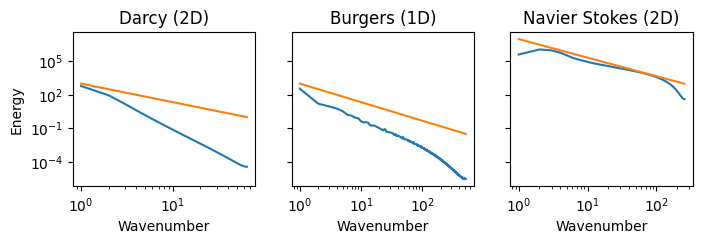

In [4]:
fig, axs = plt.subplots(1, 3, sharey='row', figsize=(8, 2))

for x_idx, dataset_name in enumerate(
    ['darcy_pdebench', 'burgers_pdebench', 'incomp_ns_pdebench', # 'ns_pdebench'
    ]
):
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    print(f'{dataset_name=}')
    img_size = 510
    title = 'Navier Stokes (2D)'

    powerlaw_coeffs = [1e3, 1e3, 1e7, 1e5]
    if dataset_name == 'ns_pdebench':
        img_size = 512
        title = 'Compressible NS'

    if dataset_name == 'darcy_pdebench':
        img_size = 128
        title = 'Darcy (2D)'

    if dataset_name == 'burgers_pdebench':
        img_size = 1024
        title = 'Burgers (1D)'
    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        _,
        _,
        _,
    ) = get_dataset_info(dataset_name, "mse")

    darcy_forcing_term = 1.0
    burger_viscosity = 0.001
    comp_ns_params = ['Turb', 1.0, 1e-08, 1e-08, 'periodic', 512]
    seed = 0     

    dataset = get_dataset(
        dataset_name=dataset_name,
        filter_lim=-1,
        img_size='na',
        downsample_dim=-1,
        train=False,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
        batch_size=128,
        seed=0,
        resolution_ratios=[1, 0, 0, 0],
        comp_ns_params=comp_ns_params,
        loss_name="na",
    )
    labels = torch.concat([dataset[i]['y'] for i in range(len(dataset))])
    if dataset_name == 'ns_pdebench':
        labels = labels[
            :, :, 2, ...
        ]  # choose specific channel [density, pressure, X Vel, Y Vel]
    label_spectrum = energy_curve_func(labels)

    x = np.linspace(1, len(label_spectrum), len(label_spectrum))
    axs[x_idx].plot(x, label_spectrum)
    axs[x_idx].plot(x, powerlaw_coeffs[x_idx]*x**(-5/3)) # on a log-log plot a linear relationship y=mx + b == c * x ^ (m)
    axs[x_idx].set_yscale('log')
    axs[x_idx].set_xscale('log')
    axs[x_idx].set_title(title)
    axs[x_idx].set_xlabel('Wavenumber')
    if x_idx == 0:
        axs[x_idx].set_ylabel('Energy')

2d energy
dataset_name='ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
loaded density, density.shape=(1000, 21, 128, 128)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 64, 64)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 32, 32)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 16, 16)
loaded pressure
loaded Vx
loaded Vy
2d energy
dataset_name='ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
loaded density, density.shape=(1000, 21, 128, 128)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 64, 64)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 32, 32)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 16, 16)
loaded pressure
loaded Vx
loaded Vy


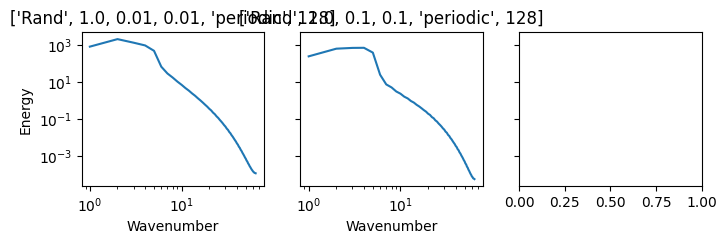

In [13]:
# compare the many compressible NS methods
fig, axs = plt.subplots(1, 3, sharey='row', figsize=(8, 2))

for x_idx, comp_ns_params in enumerate(
    [
        # ['Rand', 1.0, 1e-08, 1e-08, 'periodic', 512],
        ['Rand', 1.0, 1e-02, 1e-02, 'periodic', 128],
        ['Rand', 1.0, 1e-01, 1e-01, 'periodic', 128],
    ]
):
    for dataset_name in ['ns_pdebench']:
        if 'burgers' in dataset_name:
            print('1d energy')
            energy_curve_func = get_energy_curve_1d
        else:
            print('2d energy')
            energy_curve_func = get_energy_curve

        print(f'{dataset_name=}')
        batch_size = 128
        batch_size = 128
        in_channels = 10
        out_channels = 1
        initial_steps = 10
        filter_lim = -1
        downsample_dim = -1

        model_name = 'FNO2D'
        darcy_forcing_term = 1.0
        burger_viscosity = 0.001
        seed = 0

        if dataset_name == 'ns_pdebench':
            batch_size = 4
            in_channels = 40
            out_channels = 4
            title = 'Compressible NS'

        dataset = get_dataset(
            dataset_name=dataset_name,
            filter_lim=filter_lim,
            img_size='na',
            downsample_dim=downsample_dim,
            train=False,
            initial_steps=initial_steps,
            model_name=model_name,
            darcy_forcing_term=darcy_forcing_term,
            burger_viscosity=burger_viscosity,
            batch_size=128,
            seed=0,
            resolution_ratios=[1, 0, 0, 0],
            comp_ns_params=comp_ns_params,
        )
        labels = torch.concat([dataset[i]['y'] for i in range(len(dataset))])
        if dataset_name == 'ns_pdebench':
            labels = labels[
                :, :, 2, ...
            ]  # choose specific channel [density, pressure, X Vel, Y Vel]
        label_spectrum = energy_curve_func(labels)

        x = np.linspace(1, len(label_spectrum), len(label_spectrum))
        axs[x_idx].plot(x, label_spectrum)
        axs[x_idx].set_yscale('log')
        axs[x_idx].set_xscale('log')
        axs[x_idx].set_title(comp_ns_params)
        axs[x_idx].set_xlabel('Wavenumber')
        if x_idx == 0:
            axs[x_idx].set_ylabel('Energy')

## Visualize Burgers + Incomp NS

Looking for turbulence: vis + energy spectrum

TODO: https://github.com/pdebench/PDEBench/blob/main/pdebench/data_download/visualize_pdes.py#L168

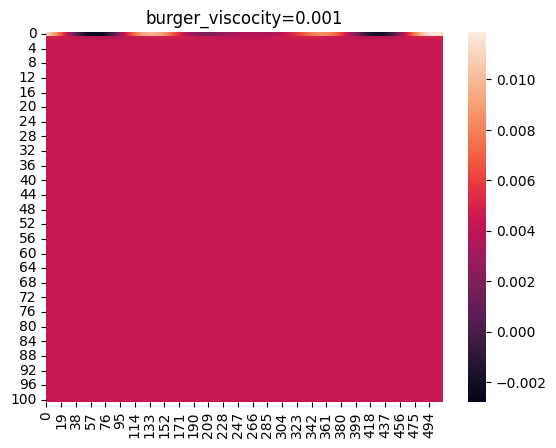

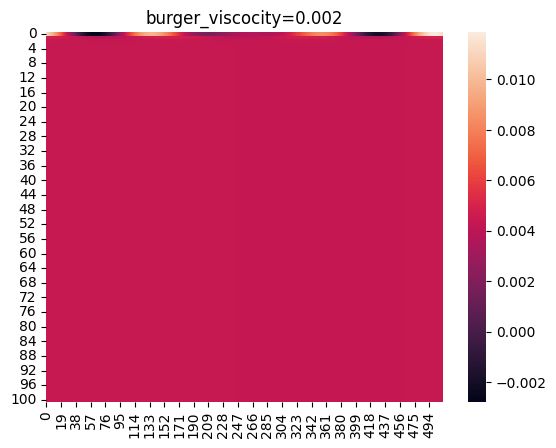

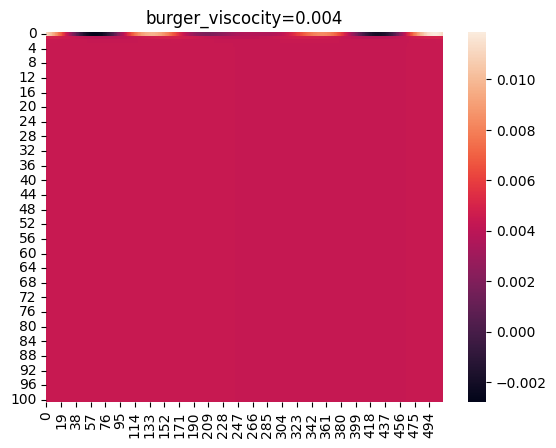

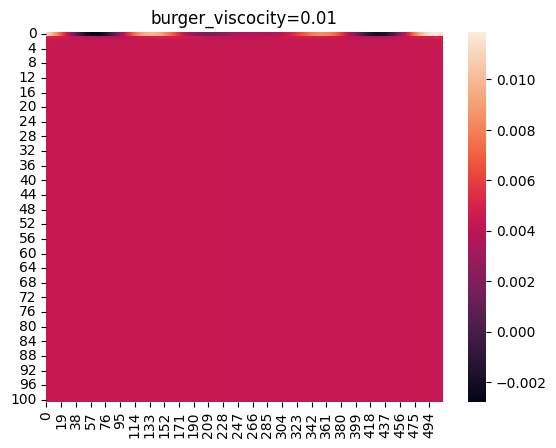

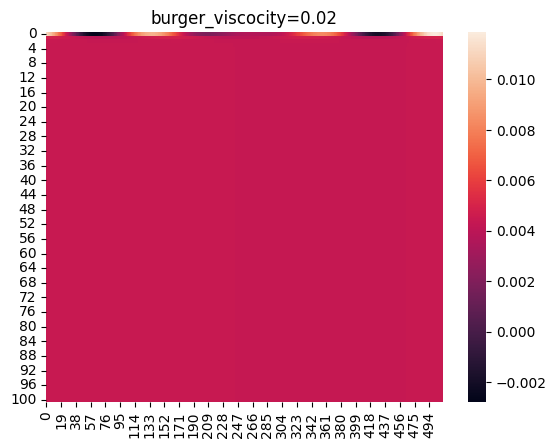

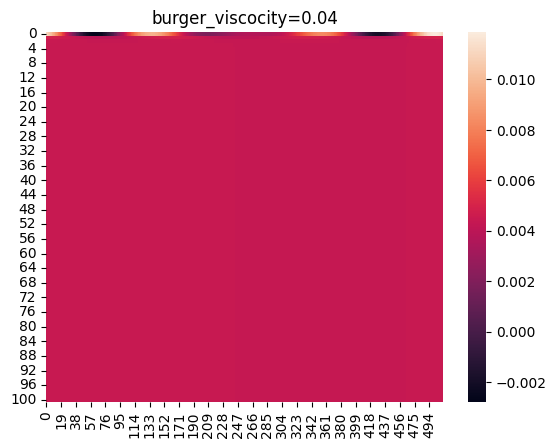

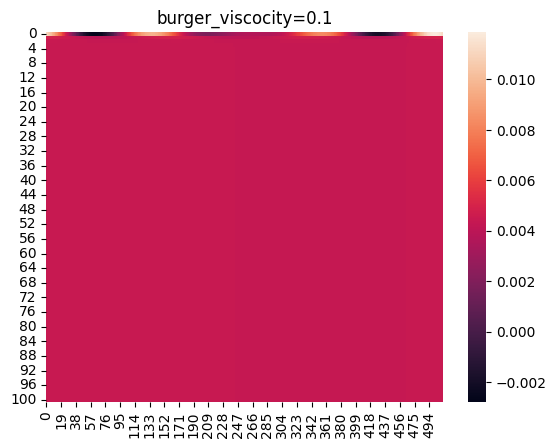

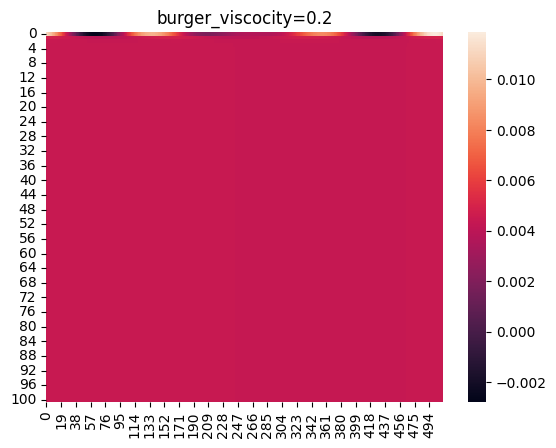

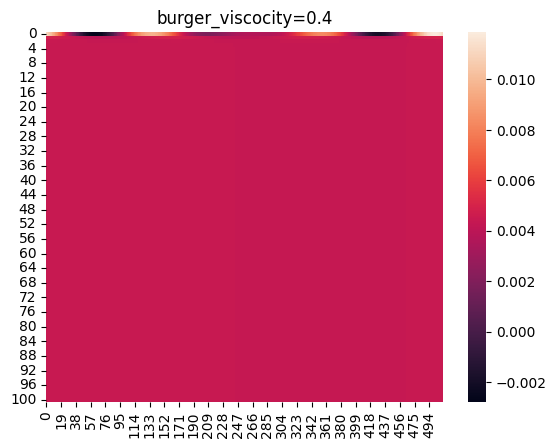

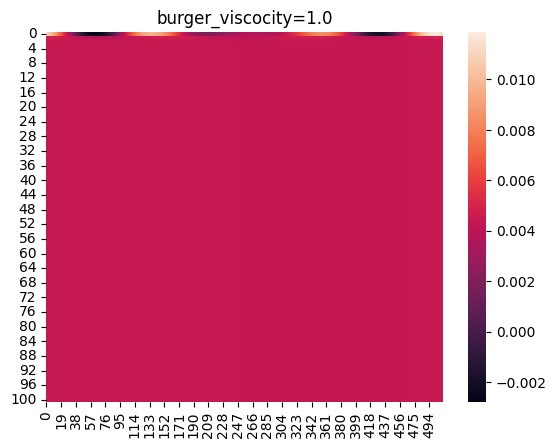

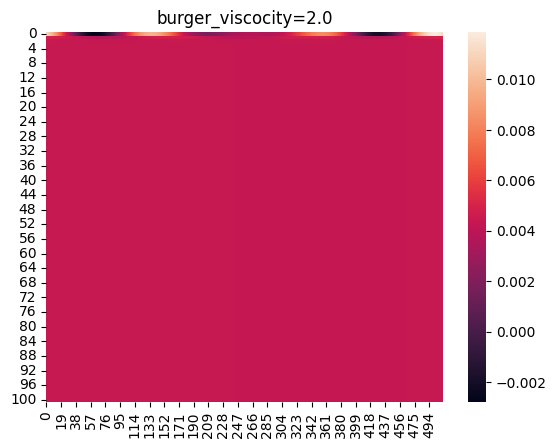

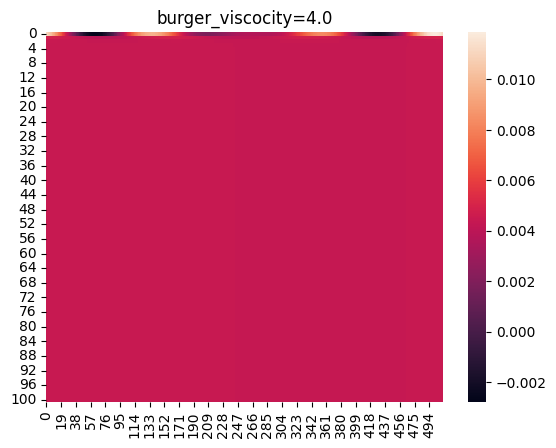

In [46]:
# vis burgers at different visocity coeffs

dataset_name = 'burgers_pdebench'
img_size = 512
max_mode = img_size // 2
in_channels = 1
out_channels = 1
initial_steps = 1
filter_lim = -1
downsample_dim = -1
model_name = 'FNO2D'
darcy_forcing_term = 1.0
burger_viscosity = 1.0

for burger_viscocity in [
    0.001,
    0.002,
    0.004,
    0.01,
    0.02,
    0.04,
    0.1,
    0.2,
    0.4,
    1.0,
    2.0,
    4.0,
]:
    dataset = get_dataset(
        dataset_name=dataset_name,
        filter_lim=filter_lim,
        img_size=img_size,
        downsample_dim=downsample_dim,
        train=False,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
    )
    x = dataset[100]['y'].squeeze()
    norm1 = x / np.linalg.norm(x)
    # plt.imshow(norm1)
    # plt.colorbar(orientation='horizontal')
    sns.heatmap(norm1)

    plt.title(f'{burger_viscocity=}')
    plt.show()

# HP Search

Find optimial HP config for darcy, burgers, and incompressible navier stokes, and compressible navier stokes

TODO: select best models!

/tmp/ipykernel_375814/1074562398.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


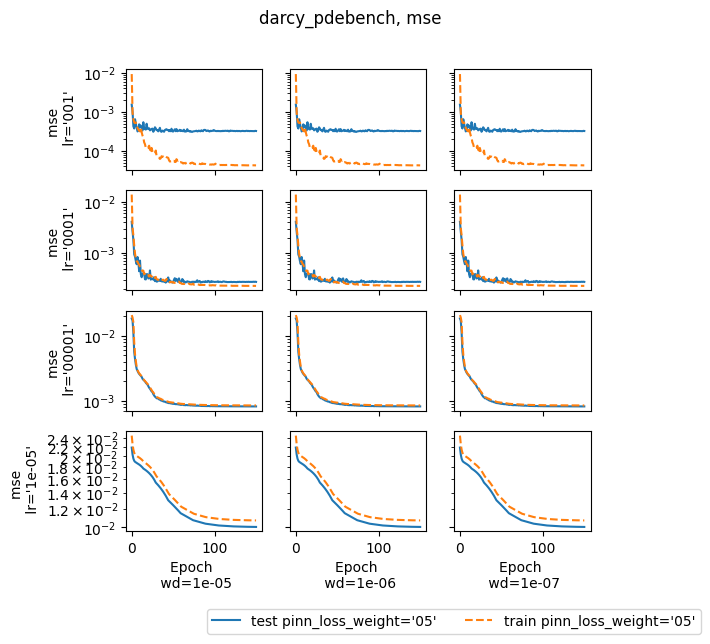

/tmp/ipykernel_375814/1074562398.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


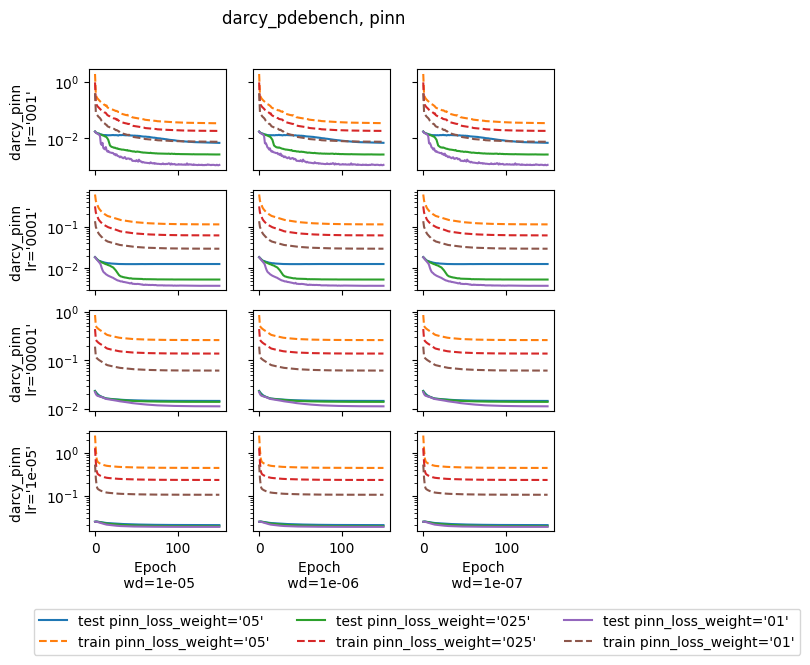

/tmp/ipykernel_375814/1074562398.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


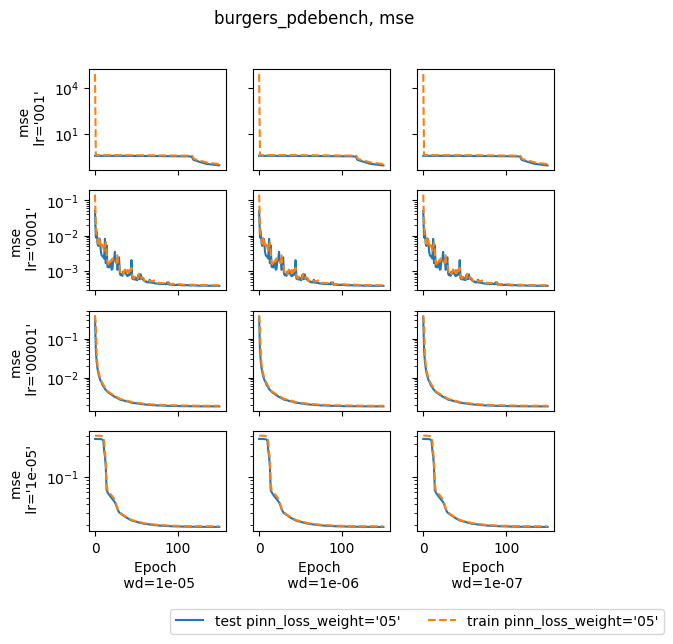

/tmp/ipykernel_375814/1074562398.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


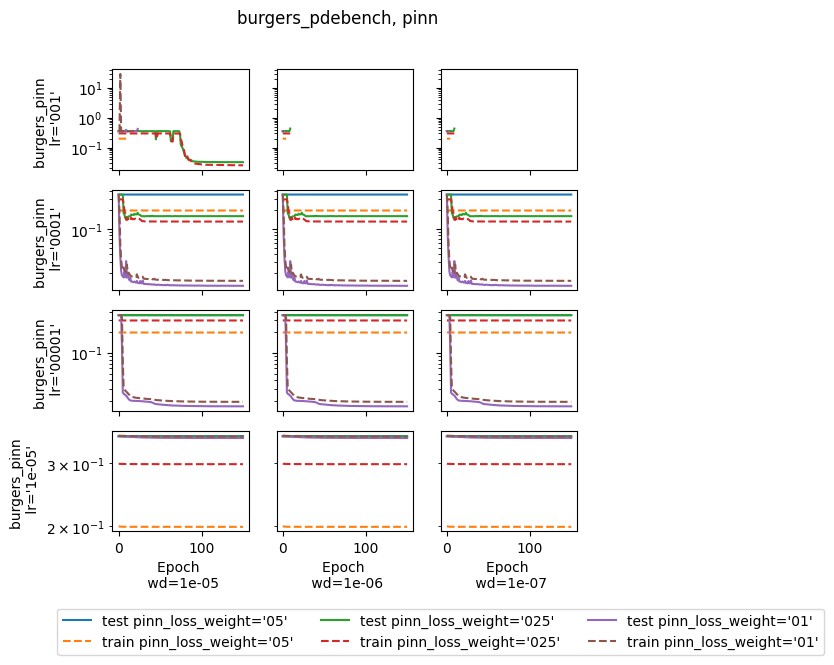

/tmp/ipykernel_375814/1074562398.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


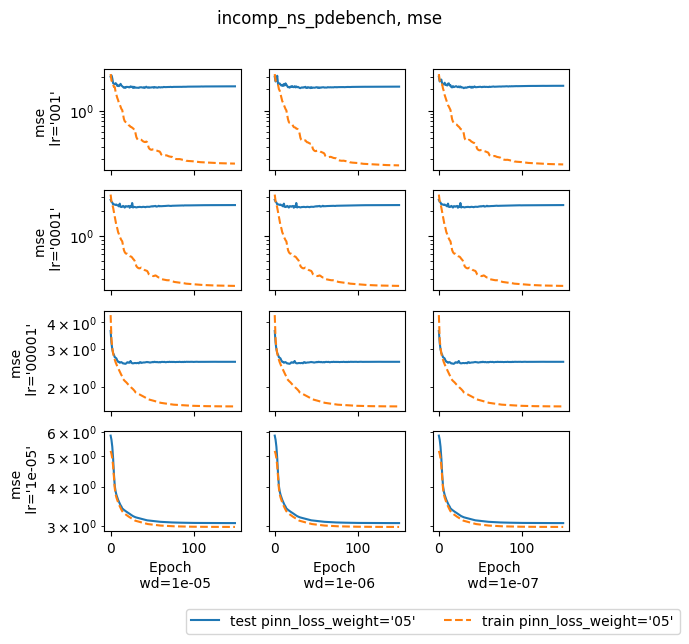

/tmp/ipykernel_375814/1074562398.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


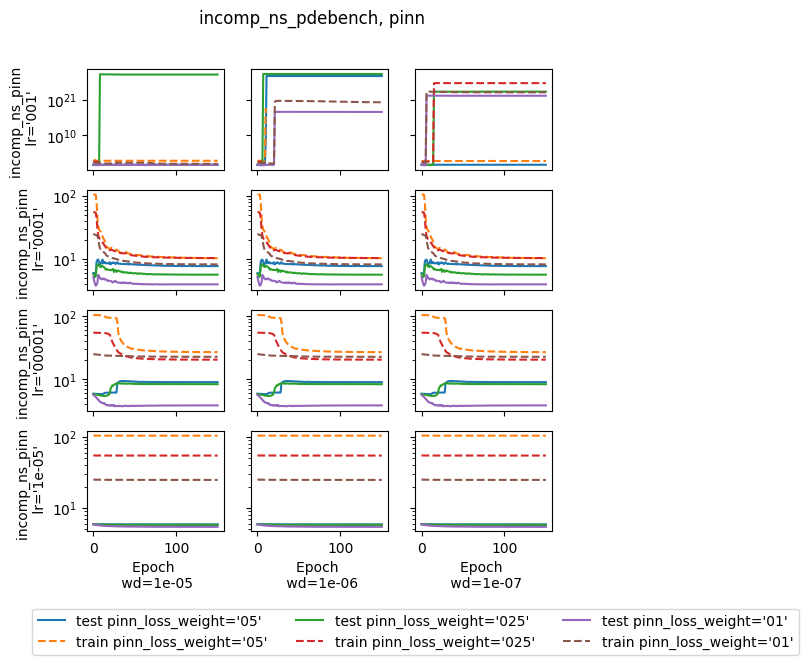

/tmp/ipykernel_375814/1074562398.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


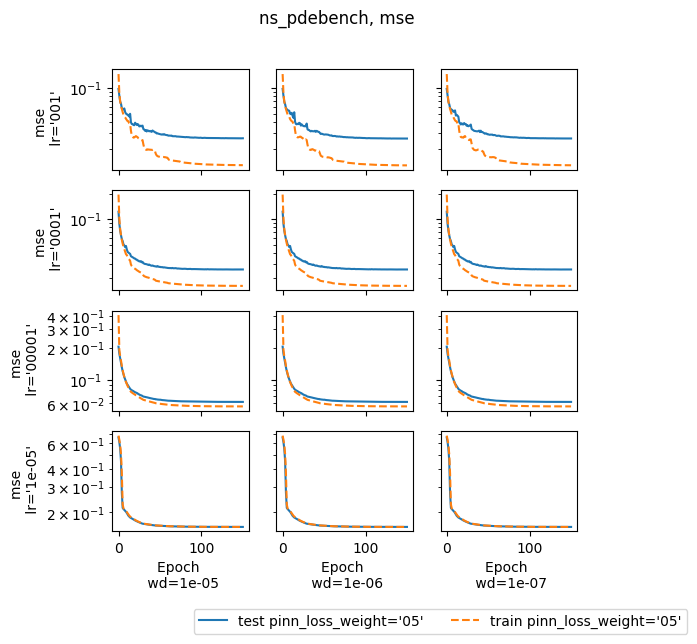

finished_exp=156, total_exp=156, 100.0 %


In [13]:
# Check if all experiments have finished
ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
total_exp = 0
finished_exp = 0
learning_rates = {'001': 1e-2, '0001': 1e-3, '00001': 1e-4, '1e-05': 1e-5}
pinn_weights = {'05': 0.5, '025': 0.25, '01': 0.1}
summary_stats = pd.DataFrame(
    columns=['data', 'loss', 'lr', 'wd', 'pinn_loss_weight', 'test']
)
for dataset_name in [
    'darcy_pdebench',
    'burgers_pdebench',
    'incomp_ns_pdebench',
    'ns_pdebench',
]:
    img_size = 255

    if dataset_name == 'ns_pdebench':
        img_size = 256

    if dataset_name == 'darcy_pdebench':
        img_size = 64

    if dataset_name == 'burgers_pdebench':
        img_size = 512

    for loss_type in ['mse', 'pinn']:
        (
            model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            _,
            _,
            _,
        ) = get_dataset_info(dataset_name, loss_type)
        if loss == 'n/a':
            continue
        fig, axes = plt.subplots(
            nrows=4, ncols=3, sharey='row', sharex='col', figsize=(6, 6)
        )
        for y_idx, lr in enumerate(['001', '0001', '00001', '1e-05']):
            for x_idx, wd in enumerate([1e-05, 1e-06, 1e-07]):
                pinn_loss_weights = ['05']
                if 'pinn' in loss_type:
                    pinn_loss_weights += ['025', '01']
                for pinn_loss_weight in pinn_loss_weights:
                    max_mode = img_size // 2
                    resolutions = str_from_res([0, 1, 0, 0])
                    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
                    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                    ckpt_name = f'{ckpt_pth}/train_stats.csv'
                    total_exp += 1
                    if not os.path.exists(ckpt_name):
                        print('does not exist: ',ckpt_name)
                        continue
                    # print(ckpt_dir)
                    df = pd.read_csv(ckpt_name)
                    for ylabel in [
                        #'train_loss',
                        'test',
                    ]:
                        if 150 in df['epoch']:
                            finished_exp += 1
                            row = df[df.epoch == 150]
                            summary_stats.loc[len(summary_stats)] = [
                                dataset_name,
                                loss,
                                learning_rates[lr],
                                wd,
                                pinn_weights[pinn_loss_weight],
                                row[ylabel].item(),
                            ]
                        else:
                            print('Not finished: ', ckpt_name)
                        sns.lineplot(
                            df,
                            x='epoch',
                            y=ylabel,
                            label=f'test {pinn_loss_weight=}',
                            ax=axes[y_idx, x_idx],
                        )
                        sns.lineplot(
                            df,
                            x='epoch',
                            y='train_loss',
                            linestyle="--",
                            label=f'train {pinn_loss_weight=}',
                            ax=axes[y_idx, x_idx],
                        )
                        axes[y_idx, x_idx].get_legend().remove()
                        axes[y_idx, x_idx].set_yscale('log')

                if y_idx == 3:
                    axes[y_idx, x_idx].set_xlabel(f'Epoch \n {wd=}')
                if x_idx == 0:
                    axes[y_idx, x_idx].set_ylabel(f'{loss} \n {lr=}')

        plt.legend(bbox_to_anchor=(0, -0.7), loc='upper center', ncols=3)

        fig.suptitle(f'{dataset_name}, {loss_type}')
        plt.tight_layout()
        plt.show()
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp * 100} %')

In [3]:
best_hps = summary_stats.loc[
    summary_stats.groupby(['data', 'loss']).test.idxmin()
]
best_hps

data            loss      lr            wd  \
66     burgers_pdebench    burgers_pinn  0.0010  1.000000e-05   
46     burgers_pdebench             mse  0.0010  1.000000e-05   
9        darcy_pdebench      darcy_pinn  0.0100  1.000000e-05   
0        darcy_pdebench             mse  0.0010  1.000000e-07   
123  incomp_ns_pdebench  incomp_ns_pinn  0.0001  1.000000e-05   
92   incomp_ns_pdebench             mse  0.0100  1.000000e-06   
143         ns_pdebench             mse  0.0010  1.000000e-06   

     pinn_loss_weight      test  
66                0.1  0.012701  
46                0.5  0.000381  
9                 0.1  0.001141  
0                 0.5  0.000274  
123               0.1  3.866482  
92                0.5  2.194969  
143               0.5  0.025513

# PINNs

TODO:
- make fig about pinn's weights
- make fig w/ ns various feilds

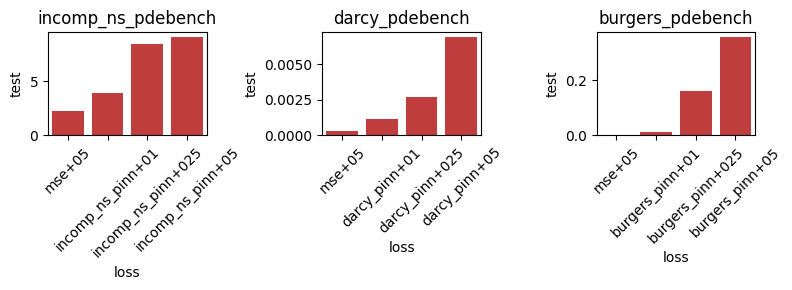

In [2]:
# Check if all experiments have finished
total_exp = 0
finished_exp = 0
learning_rates = {'001': 1e-2, '0001': 1e-3, '00001': 1e-4, '1e-05': 1e-5}
pinn_weights = {'05': 0.5, '025': 0.25, '01': 0.1}



fig, axes = plt.subplots(
            nrows=1, ncols=3, sharey=False, sharex='col', figsize=(8, 3)
        )
for x_idx, dataset_name in enumerate([
    'incomp_ns_pdebench',
    'darcy_pdebench',
    'burgers_pdebench',
    #'ns_pdebench',
]):
    summary_stats = pd.DataFrame(
        columns=['data', 'loss', 'lr', 'wd', 'pinn_loss_weight', 'test']
    )
    ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    if dataset_name == "incomp_ns_pdebench":
        img_size = 255
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'
        
    if dataset_name == 'ns_pdebench':
        img_size = 256

    if dataset_name == 'darcy_pdebench':
        img_size = 64

    if dataset_name == 'burgers_pdebench':
        img_size = 512

    for loss_type in ['mse', 'pinn']:
        (
            model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            lr,
            wd,
            _,
        ) = get_dataset_info(dataset_name, loss_type)

        if loss == 'n/a':
            continue

        pinn_loss_weights = ['05']
        if 'pinn' in loss_type:
            pinn_loss_weights = ['01','025','05']
        for pinn_loss_weight in pinn_loss_weights:
            max_mode = img_size // 2
            resolutions = str_from_res([0, 1, 0, 0])
            ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
            ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
            ckpt_pth = ckpt_pth.replace(".",'')
            ckpt_name = f'{ckpt_pth}/train_stats.csv'
            total_exp += 1
            if not os.path.exists(ckpt_name):
                print('does not exist: ', ckpt_dir)
                continue
            df = pd.read_csv(ckpt_name)
            for ylabel in [
                'test',
            ]:
                if 150 in df['epoch']:
                    finished_exp += 1
                    row = df[df.epoch == 150]
                    summary_stats.loc[len(summary_stats)] = [
                        dataset_name,
                        f"{loss}+{pinn_loss_weight}",
                        lr,
                        wd,
                        pinn_weights[pinn_loss_weight],
                        row[ylabel].item(),
                    ]
                else:
                    print('Not finished: ', ckpt_name)
                sns.barplot(
                    summary_stats,
                    x='loss',
                    y=ylabel,
                    #label=f'{pinn_loss_weight=}',
                    ax=axes[x_idx],
                )
                axes[x_idx].tick_params(axis='x', labelrotation=45)
                axes[x_idx].set_title(dataset_name)

plt.tight_layout()
plt.show()

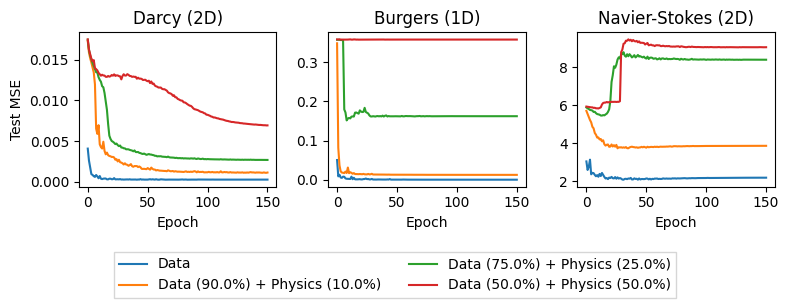

In [3]:
# Check if all experiments have finished
total_exp = 0
finished_exp = 0
learning_rates = {'001': 1e-2, '0001': 1e-3, '00001': 1e-4, '1e-05': 1e-5}
pinn_weights = {'05': 0.5, '025': 0.25, '01': 0.1}



fig, axes = plt.subplots(
            nrows=1, ncols=3, sharey=False, sharex='col', figsize=(8, 2.5)
        )
for x_idx, dataset_name in enumerate([
    'darcy_pdebench',
    'burgers_pdebench',
    'incomp_ns_pdebench',
    #'ns_pdebench',
]):
    summary_stats = pd.DataFrame(
        columns=['data', 'loss', 'lr', 'wd', 'pinn_loss_weight', 'test']
    )
    
    
    ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    if dataset_name == "incomp_ns_pdebench":
        img_size = 255
        title = "Navier-Stokes (2D)"
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'

    if dataset_name == 'ns_pdebench':
        img_size = 256

    if dataset_name == 'darcy_pdebench':
        img_size = 64
        title = "Darcy (2D)"

    if dataset_name == 'burgers_pdebench':
        img_size = 512
        title = "Burgers (1D)"

    for loss_type in ['mse', 'pinn']:
        (
            model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            lr,
            wd,
            _,
        ) = get_dataset_info(dataset_name, loss_type)

        if loss == 'n/a':
            continue

        pinn_loss_weights = ['05']
        
        if 'pinn' in loss_type:
            pinn_loss_weights = ['01','025','05']
            
        for pinn_loss_weight in pinn_loss_weights:
            label = "Data"
            if 'pinn' in loss_type:
                label = f"Data ({(1 - pinn_weights[pinn_loss_weight])* 100}%) + Physics ({pinn_weights[pinn_loss_weight]*100}%)"
            max_mode = img_size // 2
            resolutions = str_from_res([0, 1, 0, 0])
            ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
            ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
            ckpt_pth = ckpt_pth.replace(".",'')
            ckpt_name = f'{ckpt_pth}/train_stats.csv'
            total_exp += 1
            if not os.path.exists(ckpt_name):
                print('does not exist: ', ckpt_dir)
                continue
            df = pd.read_csv(ckpt_name)
            for ylabel in [
                'test',
            ]:
                if 150 in df['epoch']:
                    finished_exp += 1
                    row = df[df.epoch == 150]
                    summary_stats.loc[len(summary_stats)] = [
                        dataset_name,
                        f"{loss}+{pinn_loss_weight}",
                        lr,
                        wd,
                        pinn_weights[pinn_loss_weight],
                        row[ylabel].item(),
                    ]
                else:
                    print('Not finished: ', ckpt_name)
                sns.lineplot(
                    df,
                    x='epoch',
                    y=ylabel,
                    label=label,#f'{f"{loss}+{pinn_loss_weight}"}',
                    ax=axes[x_idx],
                )
                axes[x_idx].set_ylabel(None)
                axes[x_idx].set_title(title)
                axes[x_idx].set_xlabel("Epoch")
                handles, labels = axes[x_idx].get_legend_handles_labels()
                axes[x_idx].get_legend().remove()
                if x_idx == 0:
                    axes[x_idx].set_ylabel("Test MSE")
                

fig.legend(handles = handles , labels=labels,loc='upper center',
             bbox_to_anchor=(0.5, -0.00),fancybox=False, shadow=False, ncol=2)
plt.tight_layout()
plt.show()
fig.savefig(
            f'{FIG_DIR}/pinns_weight_tuning.pdf',
            bbox_inches='tight',
            dpi=300,
        )

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[0, 1, 0, 0]
self.num_samples=109
resolution_ratios=[0, 0, 1, 0]
self.num_samples=109
resolution_ratios=[0, 0, 0, 1]
self.num_samples=109
2d energy
dataset_name='darcy_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
1d energy
dataset_name='burgers_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000


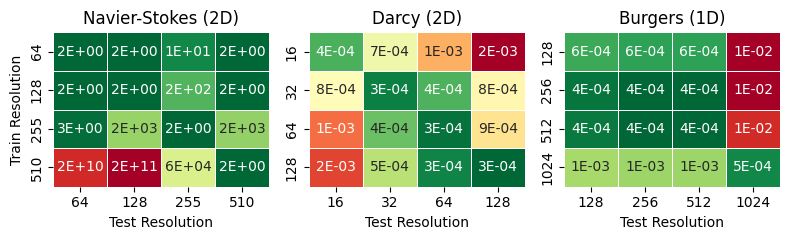

In [3]:
colors = ['red', 'green', 'blue', 'purple', 'brown', 'orange', 'pink']
total_exp = 0
finished_exp = 0
fig, axes = plt.subplots(
            nrows=1, ncols=3, sharey=False, sharex='col', figsize=(8, 2.5)
        )
for x_idx, dataset_name in enumerate([
    #'ns_pdebench',
    'incomp_ns_pdebench',
    'darcy_pdebench',
    'burgers_pdebench',
    
]):
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    print(f'{dataset_name=}')
    # if dataset_name == 'incomp_ns_pdebench':
    
    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        _,
        _,
        _,
    ) = get_dataset_info(dataset_name, "mse")
    
    title = "Navier-Stokes (2D)"
    ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    if dataset_name == "incomp_ns_pdebench":
        img_sizes = [510, 255, 128, 64]
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'
    if dataset_name == 'ns_pdebench':
        img_sizes = [512, 256, 128, 64]
        
        
    if dataset_name == 'darcy_pdebench':
        img_sizes = [128, 64, 32, 16]
        title = "Darcy (2D)"

    if dataset_name == 'burgers_pdebench':
        img_sizes = [1024, 512, 256, 128]
        title = "Burgers (1D)"

    heatmap = pd.DataFrame(columns=['Train Resolution', 'Test Resolution', 'test_loss', 'loss_name'])
    for epoch in [150]:  # 0, 50, 100, 250, 500
        
        for _x_idx, test_size in enumerate(range(len(img_sizes))):
            # get data
            test_resolutions = [0, 0, 0, 0]
            test_resolutions[test_size] = 1
            dataset = get_dataset(
                dataset_name=dataset_name,
                filter_lim=-1,
                img_size=test_size,
                downsample_dim=-1,
                train=False,
                initial_steps=initial_steps,
                model_name=model_name,
                darcy_forcing_term=darcy_forcing_term,
                burger_viscosity=burger_viscosity,
                batch_size=batch_size,
                seed=0,
                resolution_ratios=test_resolutions,
                comp_ns_params=comp_ns_params, 
            )
            test_loader = DataLoader(dataset, batch_size=1)

            for _y_idx, img_size in enumerate(range(len(img_sizes))):

                train_resolutions = [0, 0, 0, 0]
                train_resolutions[img_size] = 1
                train_resolutions = ''.join(str(train_resolutions).split())
                offset = 0
                if initial_steps == 1:
                    offset = 1

                for _y_idx, loss in enumerate(['mse', 'pinn']):
                    (
                        model_name,
                        in_channels,
                        out_channels,
                        initial_steps,
                        loss,
                        batch_size,
                        lr,
                        wd,
                        pinn_loss_w,
                    ) = get_dataset_info(dataset_name, loss)
                    lr = str(lr).replace('.', '')
                    pinn_loss_weights = [pinn_loss_w]
                    #if 'pinn' in loss:
                    #    pinn_loss_weights = ['05', '025', '01']
                    for pinn_loss_weight in pinn_loss_weights:
                        loss_type = 'Data Loss'
                        col = 'green'
                        if 'pinn' in loss:
                            loss_type = 'Data+Physics Loss'
                            col = 'orange'
    
                        max_mode = img_sizes[img_size] // 2
                        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
                        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                        ckpt_pth = ckpt_pth.replace(".",'')
                        model = get_model(
                            model_name=model_name,
                            max_modes=max_mode,
                            hidden_channels=32,
                            in_channels=in_channels,
                            out_channels=out_channels,
                        )
    
                        # ckpt_dict = load_latest_ckpt(ckpt_pth)
                        ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
                        total_exp += 1
                        if not os.path.exists(ckpt_file):
                            print('waiting for experiment: ', ckpt_file)
                            continue
                        # print("FINISHED: ", ckpt_file)
                        finished_exp += 1
                        ckpt_dict = torch.load(
                            ckpt_file,
                            weights_only=False,
                        )
                        model.load_state_dict(ckpt_dict['model_state_dict'])
                        model = model.to(device)
                        model = model.eval()
    
                        # get model pred
                        test_dict = test_model(
                            model,
                            {"test":test_loader},
                            device,
                            initial_steps,
                        )
                        #print(f"{img_size=}, {test_size=}, {test_dict=}")
                        heatmap.loc[len(heatmap)] = [img_sizes[img_size], img_sizes[test_size], test_dict['test'], loss]
                        
    pivot = heatmap[heatmap.loss_name=='mse'].pivot(index='Train Resolution', columns='Test Resolution', values='test_loss')
    sns.heatmap(pivot, ax=axes[x_idx], norm=LogNorm(), cmap='RdYlGn_r', linewidths=.5, fmt='.0E', annot=True, cbar=False)
    axes[x_idx].set_title(title)
    if x_idx > 0:
        axes[x_idx].set_ylabel('')

plt.tight_layout()
plt.show()
fig.savefig(
            f'{FIG_DIR}/multi_res_test_heatmap.pdf',
            bbox_inches='tight',
            dpi=300,
        )

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[0, 1, 0, 0]
self.num_samples=109
resolution_ratios=[0, 0, 1, 0]
self.num_samples=109
resolution_ratios=[0, 0, 0, 1]
self.num_samples=109


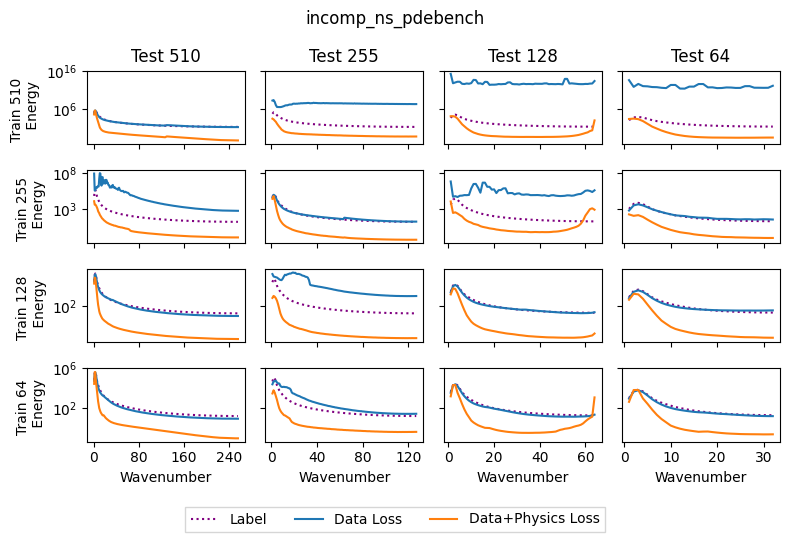

2d energy
dataset_name='darcy_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000


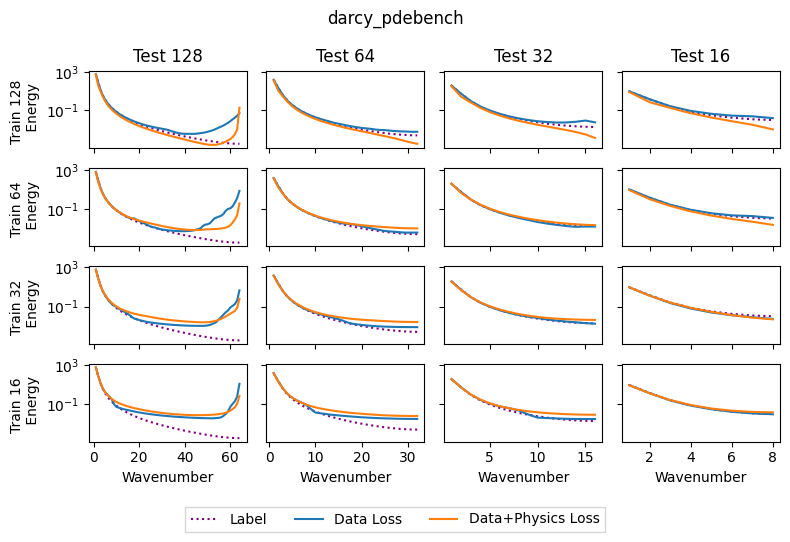

1d energy
dataset_name='burgers_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000


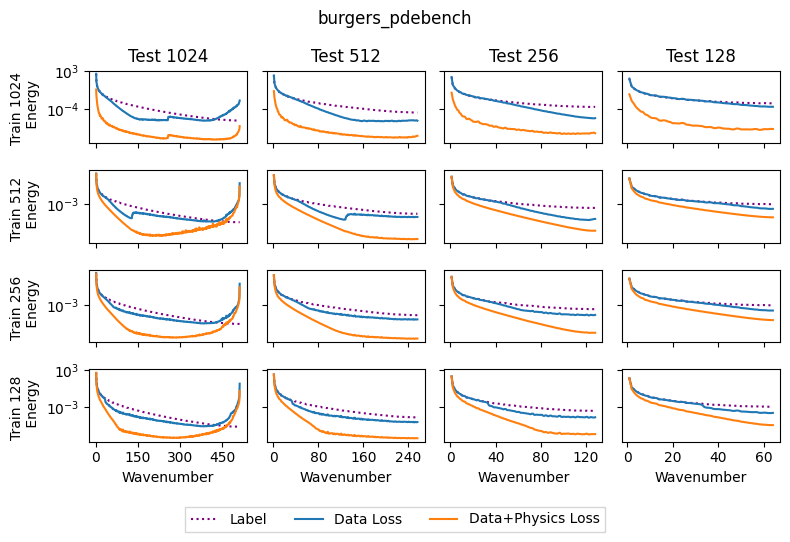

finished_exp=96, total_exp=96, 100.0 %


In [4]:
colors = ['red', 'green', 'blue', 'purple', 'brown', 'orange', 'pink']
total_exp = 0
finished_exp = 0
for dataset_name in [
    #'ns_pdebench',
    'incomp_ns_pdebench',
    'darcy_pdebench',
    'burgers_pdebench',
    
]:
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    print(f'{dataset_name=}')
    # if dataset_name == 'incomp_ns_pdebench':
    
    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        _,
        _,
        _,
    ) = get_dataset_info(dataset_name, "mse")
    ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    if dataset_name == "incomp_ns_pdebench":
        img_sizes = [510, 255, 128, 64]
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'
        
    if dataset_name == 'ns_pdebench':
        img_sizes = [512, 256, 128, 64]
        
    if dataset_name == 'darcy_pdebench':
        img_sizes = [128, 64, 32, 16]

    if dataset_name == 'burgers_pdebench':
        img_sizes = [1024, 512, 256, 128]

    for epoch in [150]:  # 0, 50, 100, 250, 500
        fig, axes = plt.subplots(
            nrows=4, ncols=4, sharey='row', sharex='col', figsize=(8, 5)
        )
        for x_idx, test_size in enumerate(range(len(img_sizes))):
            # get data
            test_resolutions = [0, 0, 0, 0]
            test_resolutions[test_size] = 1
            dataset = get_dataset(
                dataset_name=dataset_name,
                filter_lim=-1,
                img_size=test_size,
                downsample_dim=-1,
                train=False,
                initial_steps=initial_steps,
                model_name=model_name,
                darcy_forcing_term=darcy_forcing_term,
                burger_viscosity=burger_viscosity,
                batch_size=batch_size,
                seed=0,
                resolution_ratios=test_resolutions,
                comp_ns_params=comp_ns_params, 
            )
            test_loader = DataLoader(dataset, batch_size=1)

            for y_idx, img_size in enumerate(range(len(img_sizes))):
                if y_idx == 3:
                    axes[y_idx, x_idx].set_xlabel('Wavenumber')
                if x_idx == 0:
                    axes[y_idx, x_idx].set_ylabel(
                        f'Train {(img_sizes[img_size])} \n Energy'
                    )
                if y_idx == 0:
                    axes[y_idx, x_idx].set_title(
                        f'Test {(img_sizes[test_size])}'
                    )

                train_resolutions = [0, 0, 0, 0]
                train_resolutions[img_size] = 1
                train_resolutions = ''.join(str(train_resolutions).split())
                offset = 0
                if initial_steps == 1:
                    offset = 1
                label_spectrum = energy_curve_func(
                    torch.concat(
                        [
                            test_loader.dataset[i]['y'][:, initial_steps - offset:, ...]
                            for i in range(len(test_loader))
                        ]
                    )
                )

                x = np.linspace(1, len(label_spectrum), len(label_spectrum))
                axes[y_idx, x_idx].plot(
                    x,
                    label_spectrum,
                    label='Label',
                    color='purple',
                    linestyle=':',
                )
                for _y_idx, loss in enumerate(['mse', 'pinn']):
                    (
                        model_name,
                        in_channels,
                        out_channels,
                        initial_steps,
                        loss,
                        batch_size,
                        lr,
                        wd,
                        pinn_loss_w,
                    ) = get_dataset_info(dataset_name, loss)
                    lr = str(lr).replace('.', '')
                    pinn_loss_weights = [pinn_loss_w]
                    #if 'pinn' in loss:
                    #    pinn_loss_weights = ['05', '025', '01']
                    for pinn_loss_weight in pinn_loss_weights:
                        loss_type = 'Data Loss'
                        col = 'green'
                        if 'pinn' in loss:
                            loss_type = 'Data+Physics Loss'
                            col = 'orange'
    
                        max_mode = img_sizes[img_size] // 2
                        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
                        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                        ckpt_pth = ckpt_pth.replace(".",'')
                        model = get_model(
                            model_name=model_name,
                            max_modes=max_mode,
                            hidden_channels=32,
                            in_channels=in_channels,
                            out_channels=out_channels,
                        )
    
                        # ckpt_dict = load_latest_ckpt(ckpt_pth)
                        ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
                        total_exp += 1
                        if not os.path.exists(ckpt_file):
                            print('waiting for experiment: ', ckpt_file)
                            continue
                        # print("FINISHED: ", ckpt_file)
                        finished_exp += 1
                        ckpt_dict = torch.load(
                            ckpt_file,
                            weights_only=False,
                        )
                        model.load_state_dict(ckpt_dict['model_state_dict'])
                        model = model.to(device)
                        model = model.eval()
    
                        # get model pred
                        model_preds_test = get_model_preds(
                            test_loader, model, device, initial_steps
                        )  # .squeeze()
    
                        model_pred_spectrum = energy_curve_func(
                            model_preds_test  # .squeeze()
                        )
    
                        axes[y_idx, x_idx].set_yscale('log')
                        axes[y_idx, x_idx].plot(
                            x,
                            model_pred_spectrum,
                            label=f'{loss_type}',
                            #color=col,
                        )
                        axes[y_idx, x_idx].xaxis.set_major_locator(
                                ticker.MaxNLocator(integer=True, nbins=4)
                            )
    
                        handles, labels = axes[
                            y_idx, x_idx
                        ].get_legend_handles_labels()

        fig.legend(
            handles=handles,
            labels=labels,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.0),
            fancybox=False,
            shadow=False,
            ncol=4,
        )
        fig.suptitle(f'{dataset_name}')
        plt.tight_layout()
        plt.show()
        fig.savefig(
            f'{FIG_DIR}/{dataset_name}_pinn_vs_no_pinn_label_spectrums.pdf',
            bbox_inches='tight',
            dpi=300,
        )
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp * 100} %')

# Compound aliasing over time w/ Burgers/Incompressible NS/Compressible NS

TODO: show that aliasing gets worse over time w/ autoregressive inference

NOTE: normalizatoin causes NAN spectrums for residuals???

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109


/tmp/ipykernel_2141898/4938625.py:106: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.sharey(plt.subplot(3,4,4))


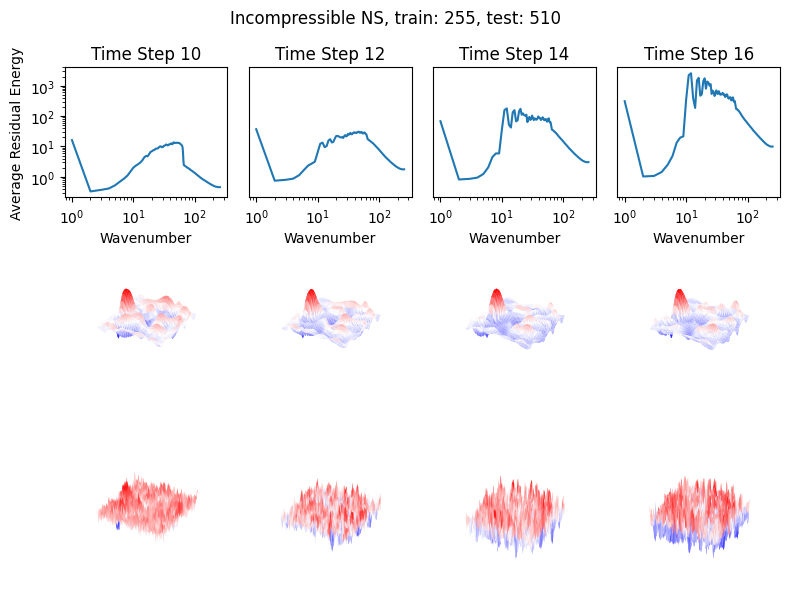

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[0, 1, 0, 0]
self.num_samples=109


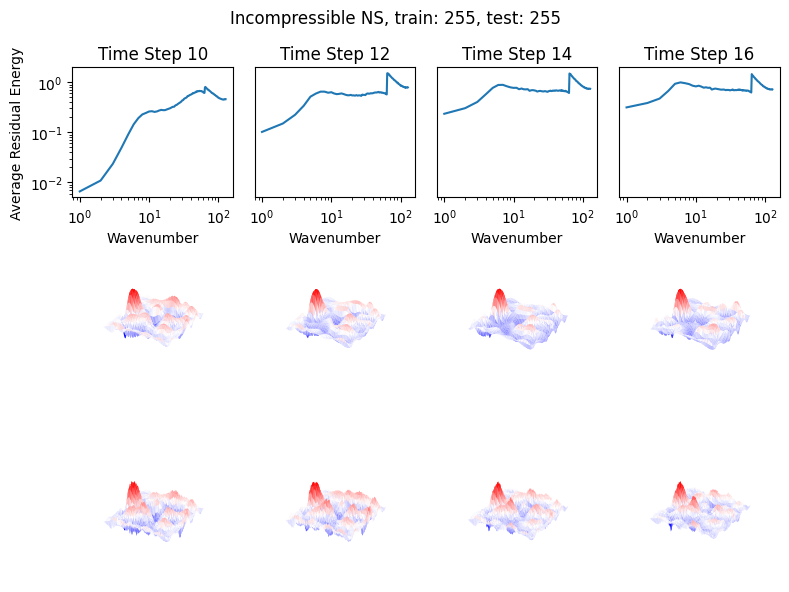

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[0, 0, 1, 0]
self.num_samples=109


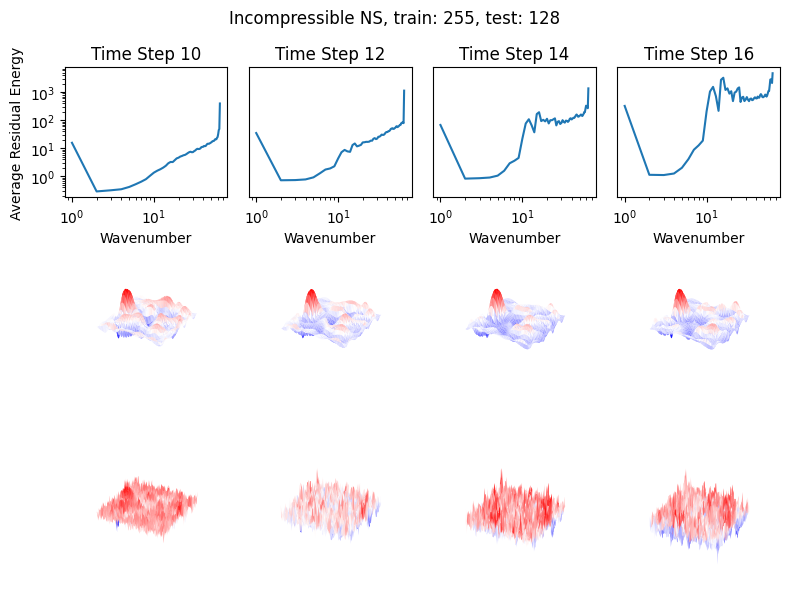

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[0, 0, 0, 1]
self.num_samples=109


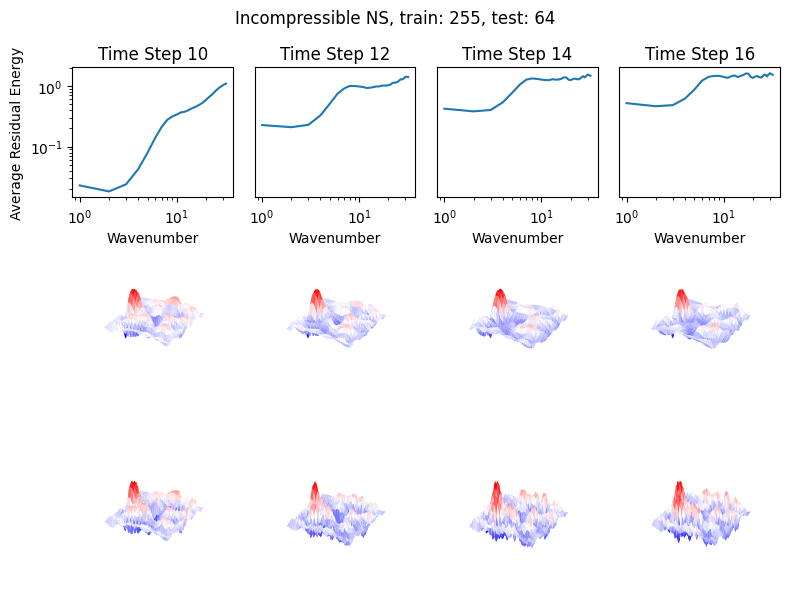

In [66]:
for test_res in range(4):
    for dataset_name in ['incomp_ns_pdebench']:
        #fig, axs = plt.subplots(4, 4, sharey='row', sharex=False, figsize=(10, 10))
        fig = plt.figure(1, figsize=(8, 6))
        if 'burgers' in dataset_name:
            print('1d energy')
            energy_curve_func = get_energy_curve_1d
        else:
            print('2d energy')
            energy_curve_func = get_energy_curve
    
        print(f'{dataset_name=}')
        (
                model_name,
                in_channels,
                out_channels,
                initial_steps,
                loss,
                batch_size,
                lr,
                wd,
                _,
            ) = get_dataset_info(dataset_name, 'mse')
    
        if dataset_name == 'incomp_ns_pdebench':
            img_sizes = [17, 85, 255, 510]
            batch_size = 4
            title = 'Incompressible NS'
            max_mode = 255 // 2  # TODO Change
    
        train_resolutions = '[0,1,0,0]'
    
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_{downsample_dim}_{filter_lim}_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
        ckpt_dir = ckpt_dir.replace(".","")
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        model = get_model(
            model_name=model_name,
            max_modes=max_mode,
            hidden_channels=32,
            in_channels=in_channels,
            out_channels=out_channels,
        )
    
        # ckpt_dict = load_latest_ckpt(ckpt_pth)
        ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
        if not os.path.exists(ckpt_file):
            print('waiting for experiment: ', ckpt_file)
            continue
        ckpt_dict = torch.load(
            ckpt_file,
            weights_only=False,
        )
        model.load_state_dict(ckpt_dict['model_state_dict'])
        model = model.to(device)
        model = model.eval()
    
        # Test at specific resolution
        test_resolutions = [0, 0, 0, 0]
        test_resolutions[test_res] = 1
        dataset = get_dataset(
            dataset_name=dataset_name,
            filter_lim=filter_lim,
            img_size='na',
            downsample_dim=downsample_dim,
            train=False,
            initial_steps=initial_steps,
            model_name=model_name,
            darcy_forcing_term=darcy_forcing_term,
            burger_viscosity=burger_viscosity,
            batch_size=4,
            seed=0,
            resolution_ratios=test_resolutions,
            comp_ns_params=comp_ns_params,
            loss_name="na"
        )
    
        test_loader = torch.utils.data.DataLoader(dataset, batch_size=1)
        model_output = get_model_preds(
            test_loader=test_loader,
            model=model,
            device=device,
            initial_steps=initial_steps,
        )
        # iteratate through time
        for x_idx, t in enumerate(range(4)):
            labels = torch.concat(
                [dataset[i]['y'] for i in range(len(dataset))]
            )[
                :, initial_steps + (t) * 2 , ...
            ].to(device)
    
            residuals = (
                model_output[:, (t) * 2 , ...] - labels
            )  # / labels
            
            # label_spectrum = energy_curve_func(labels)
            residual_spectrum = energy_curve_func(residuals)
            label_spectrum = energy_curve_func(labels)
    
            x = np.linspace(1, len(residual_spectrum), len(residual_spectrum))
            ax = plt.subplot(3,4, x_idx+1)
            ax.plot(x, residual_spectrum / label_spectrum)
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.sharey(plt.subplot(3,4,4))
            if x_idx > 0:
                ax.get_yaxis().set_visible(False)
            ax.set_title(f'Time Step {initial_steps + t*2}')
            ax.set_xlabel('Wavenumber')
            
            # 3D render of label
            dim = labels.shape[-1]
            # Create a 1D array with 25 evenly spaced numbers between 0 and 1
            array_1d = np.linspace(0, 1, num=dim*dim)
            # Reshape the 1D array into a 2D array
            x = array_1d.reshape(dim, dim)
            y = x.copy().T
            z = labels[0,0,...].cpu()
            ax = plt.subplot(3,4, x_idx+1 + 4, projection='3d')
            ax.plot_surface(x, y, z, cmap='bwr')
            ax.set_axis_off()
    
            # model prediction
            z = model_output[0, (t) * 2 , ...][0,...].cpu()
            ax = plt.subplot(3,4, x_idx+1 + 8, projection='3d')
            ax.plot_surface(x, y, z, cmap='bwr')
            ax.set_axis_off()
    
            plt.subplot(3,4, 1).set_ylabel('Average Residual Energy')
            plt.subplot(3,4, 5).set_zlabel('Example Label')
            plt.subplot(3,4, 9).set_zlabel('Example Model Prediction')
    
        fig.suptitle(f"{title}, train: 255, test: {dim}")
        plt.tight_layout()
        plt.show()

1d energy
dataset_name='burgers_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000


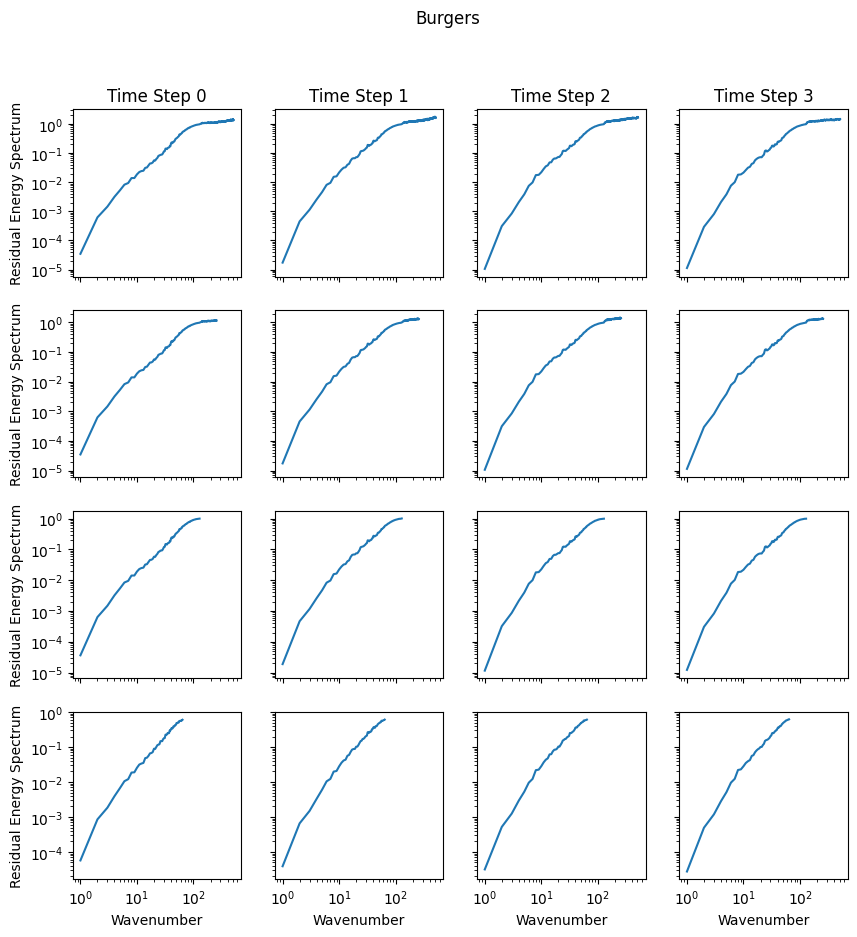

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[0, 1, 0, 0]
self.num_samples=109
resolution_ratios=[0, 0, 1, 0]
self.num_samples=109
resolution_ratios=[0, 0, 0, 1]
self.num_samples=109


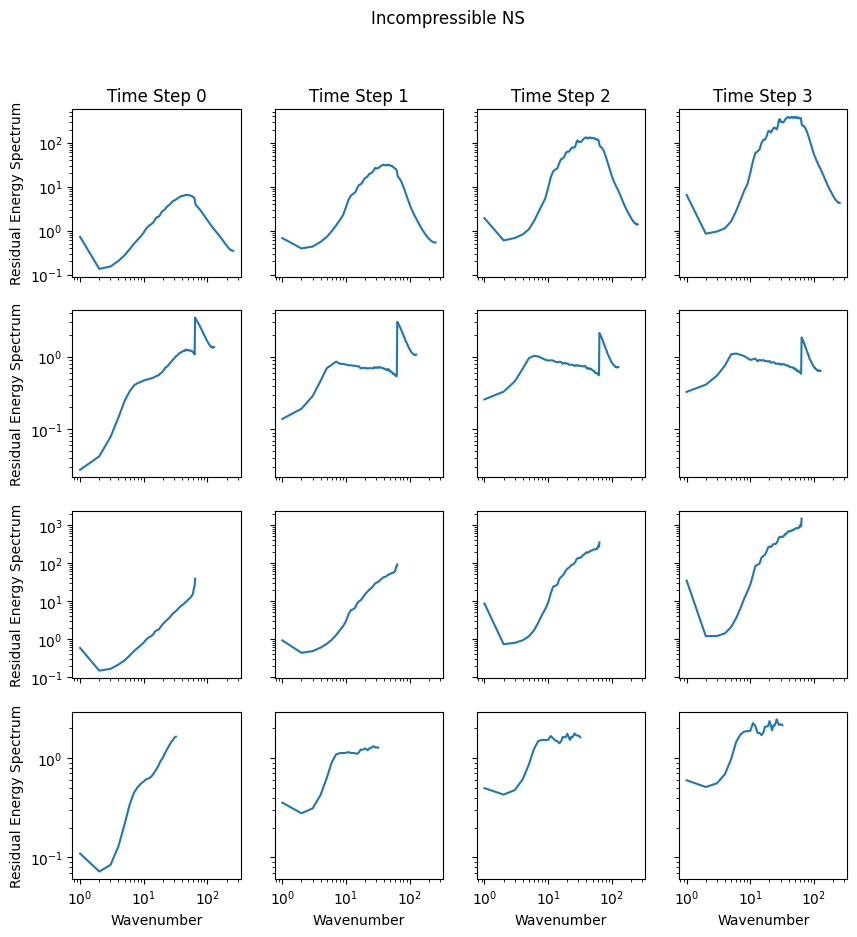

2d energy
dataset_name='ns_pdebench'
waiting for experiment:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_single_0_1_0_0//150_ckpt.pth


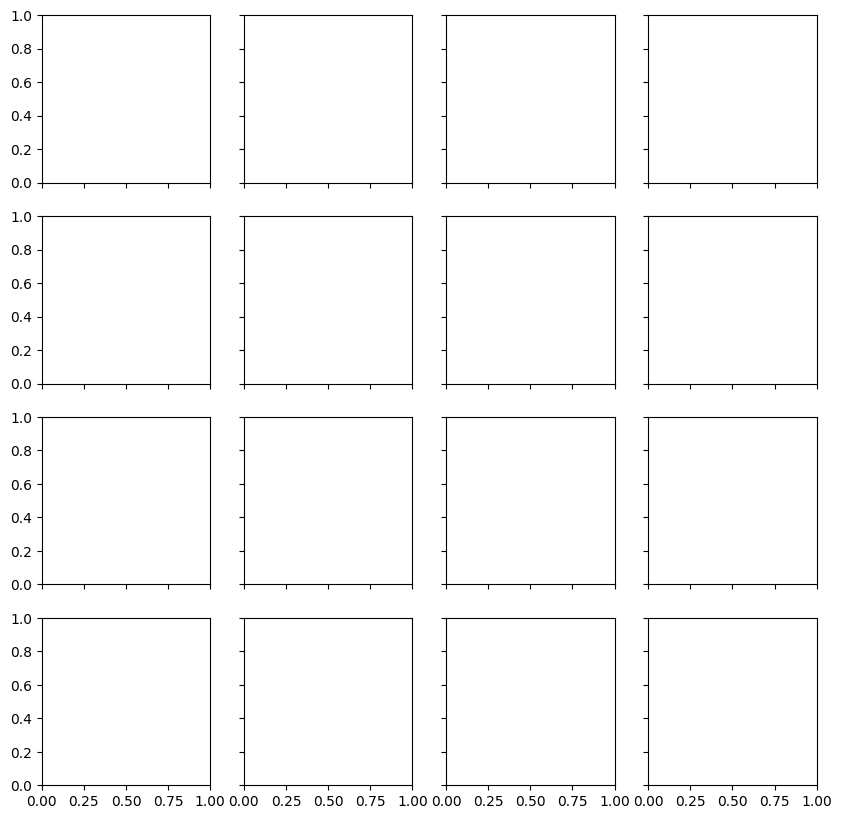

In [10]:
for dataset_name in ['burgers_pdebench', 'incomp_ns_pdebench', 'ns_pdebench']:
    fig, axs = plt.subplots(4, 4, sharey=True, sharex='col', figsize=(10, 10))
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    print(f'{dataset_name=}')
    batch_size = 128
    batch_size = 128
    in_channels = 10
    out_channels = 1
    initial_steps = 10
    filter_lim = -1
    downsample_dim = -1

    model_name = 'FNO2D'
    darcy_forcing_term = 1.0
    burger_viscosity = 0.001
    comp_ns_params = ['Turb', 1.0, 1e-08, 1e-08, 'periodic', 512]
    seed = 0
    lr = '0001'
    wd = 1e-5
    pinn_loss_weight = '05'
    loss = 'mse'

    epoch = 150

    if dataset_name == 'burgers_pdebench':
        img_sizes = [128, 256, 512, 1024]
        batch_size = 64
        model_name = 'FNO1D'
        title = 'Burgers'
        max_mode = 512 // 2  # TODO Change

    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [17, 85, 255, 510]
        batch_size = 4
        title = 'Incompressible NS'
        max_mode = 255 // 2  # TODO Change

    if dataset_name == 'ns_pdebench':
        batch_size = 4
        in_channels = 40
        out_channels = 4
        title = 'Compressible NS'
        max_mode = 512 // 2  # TODO Change

    train_resolutions = '[0,1,0,0]'

    #ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{train_resolutions}'
    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_{downsample_dim}_{filter_lim}_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
    ckpt_dir = ckpt_dir.replace(".","")
    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
    model = get_model(
        model_name=model_name,
        max_modes=max_mode,
        hidden_channels=32,
        in_channels=in_channels,
        out_channels=out_channels,
    )

    # ckpt_dict = load_latest_ckpt(ckpt_pth)
    ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
    if not os.path.exists(ckpt_file):
        print('waiting for experiment: ', ckpt_file)
        continue
    ckpt_dict = torch.load(
        ckpt_file,
        weights_only=False,
    )
    model.load_state_dict(ckpt_dict['model_state_dict'])
    model = model.to(device)
    model = model.eval()

    # iterate through resolutions
    for y_idx, res in enumerate(range(4)):
        test_resolutions = [0, 0, 0, 0]
        test_resolutions[res] = 1
        dataset = get_dataset(
            dataset_name=dataset_name,
            filter_lim=filter_lim,
            img_size='na',
            downsample_dim=downsample_dim,
            train=False,
            initial_steps=initial_steps,
            model_name=model_name,
            darcy_forcing_term=darcy_forcing_term,
            burger_viscosity=burger_viscosity,
            batch_size=4,
            seed=0,
            resolution_ratios=test_resolutions,
            comp_ns_params=comp_ns_params,
            loss_name="na"
        )

        test_loader = torch.utils.data.DataLoader(dataset, batch_size=1)
        model_output = get_model_preds(
            test_loader=test_loader,
            model=model,
            device=device,
            initial_steps=initial_steps,
        )
        # iteratate through time
        for x_idx, t in enumerate(range(4)):
            labels = torch.concat(
                [dataset[i]['y'] for i in range(len(dataset))]
            )[
                :, initial_steps + (t) * 2 : initial_steps + (t + 1) * 2, ...
            ].to(device)
            if dataset_name == 'ns_pdebench':
                labels = torch.concat(
                    [dataset[i]['y'] for i in range(len(dataset))]
                )[
                    :,
                    initial_steps + (t) * 2 : initial_steps + (t + 1) * 2,
                    2,
                    ...,
                ].to(device)
                # choose specific channel [density, pressure, X Vel, Y Vel]
            residuals = (
                model_output[:, (t) * 2 : (t + 1) * 2, ...] - labels
            )  # / labels

            # label_spectrum = energy_curve_func(labels)
            residual_spectrum = energy_curve_func(residuals)
            label_spectrum = energy_curve_func(labels)

            x = np.linspace(1, len(residual_spectrum), len(residual_spectrum))
            axs[y_idx, x_idx].plot(x, residual_spectrum / label_spectrum)

            axs[y_idx, x_idx].set_yscale('log')
            axs[y_idx, x_idx].set_xscale('log')

            if y_idx == 3:
                axs[y_idx, x_idx].set_xlabel('Wavenumber')
            if y_idx == 0:
                axs[y_idx, x_idx].set_title(f'Time Step {t}')
            if x_idx == 0:
                axs[y_idx, x_idx].set_ylabel('Residual Energy Spectrum')

    fig.suptitle(title)
    plt.show()

# Filter/ Downsample Experiments

TODO: show that w/ filters/downsampling the 

2d energy
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_8_255_FNO2D_10_1_05_10_single_1_0_0_0//150_ckpt.pth
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_16_255_FNO2D_10_1_05_10_single_1_0_0_0//150_ckpt.pth
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_32_255_FNO2D_10_1_05_10_single_1_0_0_0//150_ckpt.pth
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109


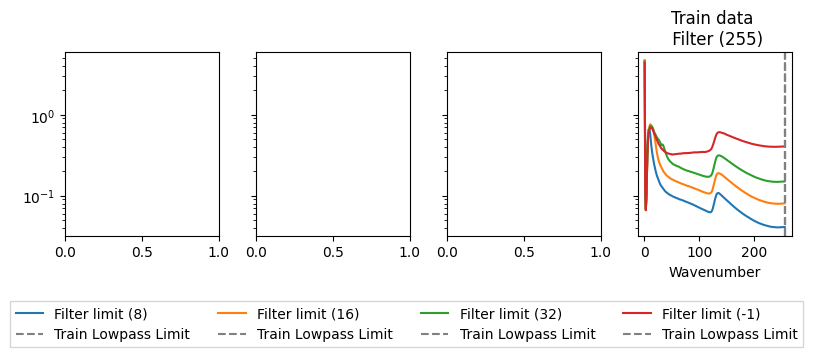

2d energy
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.

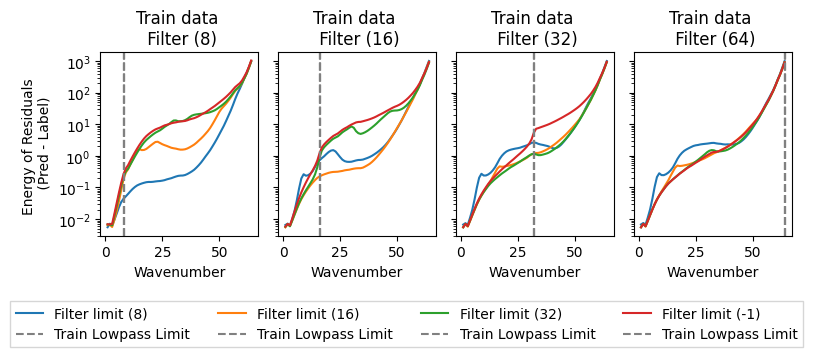

1d energy
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.

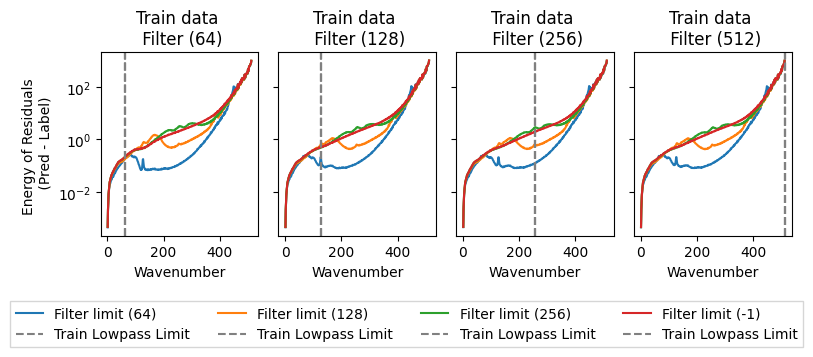

finished_exp=9, total_exp=12, 75.0 %


In [19]:
darcy_forcing_term = 1.0
burger_viscosity = 0.001
seed = 0
total_exp = 0
finished_exp = 0

for dataset_name in [
    'incomp_ns_pdebench',
    'darcy_pdebench',
    'burgers_pdebench',
    #'ns_pdebench',
]:
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'        
    if dataset_name == 'darcy_pdebench':
        img_size = 128
        fixed_lim = 8
        filter_lims = [8, 16, 32, -1]  # -1 finished
        downsample_dims = [16, 32, 64, -1]  # 16 finished

    if dataset_name == 'burgers_pdebench':
        img_size = 1024
        model_name = 'FNO1D'
        fixed_lim = 64
        filter_lims = [64, 128, 256, -1]  # -1 finished
        downsample_dims = [128, 256, 512, -1]  # 128 finished

    if dataset_name == 'incomp_ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 510
        fixed_lim = 32  # half of 64 // 2
        filter_lims = [8, 16, 32, -1]  # -1 finished
        downsample_dims = [64, 128, 255, -1]  # 85 finished
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'

    if dataset_name == 'ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 512
        fixed_lim = 32
        filter_lims = [32, 64, 128, -1]  # -1 finished
        downsample_dims = [64, 128, 256, -1]  # 64 finished

    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        lr,
        wd,
        pinn_loss_weight,
    ) = get_dataset_info(dataset_name, "mse")
    train_resolutions = [1,0,0,0]
    fig, axes = plt.subplots(
        nrows=1, ncols=4, sharey=True, sharex='col', figsize=(8, 3)
    )
    for epoch in [150]:  # 0, 50, 100, 250,
        for _y_idx, downsample_dim in enumerate([-1]):
            for x_idx, filter_lim in enumerate(filter_lims):
                if filter_lim == -1 and downsample_dim != -1:
                    continue
                max_mode = img_size // 2
                ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_{downsample_dim}_{filter_lim}_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
                ckpt_dir = ckpt_dir.replace(".","")
                ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
                total_exp += 1
                if not os.path.exists(ckpt_file):
                    print(f'Does not exists: {ckpt_file}')
                    continue
                finished_exp += 1
                ckpt_name = f'{ckpt_pth}/train_stats.csv'
                df = pd.read_csv(ckpt_name)
                # load model
                model = get_model(
                    model_name=model_name,
                    out_channels=out_channels,
                    in_channels=in_channels,
                    hidden_channels=32,
                    max_modes=max_mode,
                ).to(device)
                ckpt_dict = torch.load(
                    ckpt_file,
                    weights_only=False,
                )
                model.load_state_dict(ckpt_dict['model_state_dict'])

                # get data at various sizes
                for test_filt in filter_lims:
                    dataset = get_dataset(
                        dataset_name=dataset_name,
                        filter_lim=test_filt,
                        img_size='n/a',
                        downsample_dim=-1,
                        train=False,
                        initial_steps=initial_steps,
                        model_name=model_name,
                        darcy_forcing_term=darcy_forcing_term,
                        burger_viscosity=burger_viscosity,
                        batch_size=batch_size,
                        seed=0,
                        resolution_ratios=train_resolutions,
                        loss_name="n/a",
                    )
                    test_loader = DataLoader(dataset, batch_size=1)
                    
                    dataset = get_dataset(
                        dataset_name=dataset_name,
                        filter_lim=-1,
                        img_size='n/a',
                        downsample_dim=-1,
                        train=False,
                        initial_steps=initial_steps,
                        model_name=model_name,
                        darcy_forcing_term=darcy_forcing_term,
                        burger_viscosity=burger_viscosity,
                        batch_size=batch_size,
                        seed=0,
                        resolution_ratios=train_resolutions,
                        loss_name="n/a",
                    )
                    unfilter_test_loader = DataLoader(dataset, batch_size=1)

                    # get model preds
                    model_preds_test = get_model_preds(
                        test_loader, model, device, initial_steps
                    )
                    offset = 0
                    if initial_steps == 1:
                        offset = 1
                    labels = torch.concat(
                        [
                            test_loader.dataset[i]['y'][:, initial_steps-offset:, ...]
                            for i in range(len(test_loader))
                        ]
                    )
                    unfilter_labels = torch.concat(
                        [
                            unfilter_test_loader.dataset[i]['y'][:, initial_steps - offset:, ...]
                            for i in range(len(unfilter_test_loader))
                        ]
                    )
                    residuals = (model_preds_test - labels.to(device))
                    unfilter_label_spectrum = energy_curve_func(
                        unfilter_labels
                    )
                    residual_spectrum = energy_curve_func(residuals)

                    x = np.linspace(
                        1, len(residual_spectrum), len(residual_spectrum)
                    )
                    axes[x_idx].set_yscale('log')
                    axes[x_idx].plot(
                        x,
                        residual_spectrum / unfilter_label_spectrum,
                        label=f'Filter limit ({test_filt})',
                    )
                    f_lim = filter_lim
                    if filter_lim == -1:
                        f_lim = max_mode
                    axes[x_idx].axvline(
                        x=f_lim,
                        color='grey',
                        linestyle='--',
                        label='Train Lowpass Limit',
                    )
                    axes[x_idx].set_title(
                        f'Train data \n Filter ({f_lim})'
                    )
                    axes[x_idx].set_xlabel('Wavenumber')
                    if x_idx == 0:
                        axes[x_idx].set_ylabel(
                            'Energy of Residuals \n (Pred - Label)'
                        )
                    handles, labels = axes[
                        x_idx
                    ].get_legend_handles_labels()
    
        fig.legend(
            handles=handles,
            labels=labels,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.0),
            fancybox=False,
            shadow=False,
            ncol=4,
        )
        plt.tight_layout()
        plt.show()
        # fig.savefig(
        #    f'{FIG_DIR}/varried_downsample_{epoch}_w_max_modes.png',
        #    dpi=300,
        #    bbox_inches='tight',
        # )
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp * 100} %')

2d energy
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_64_32_255_FNO2D_10_1_05_10_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_128_32_255_FNO2D_10_1_05_10_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolutio

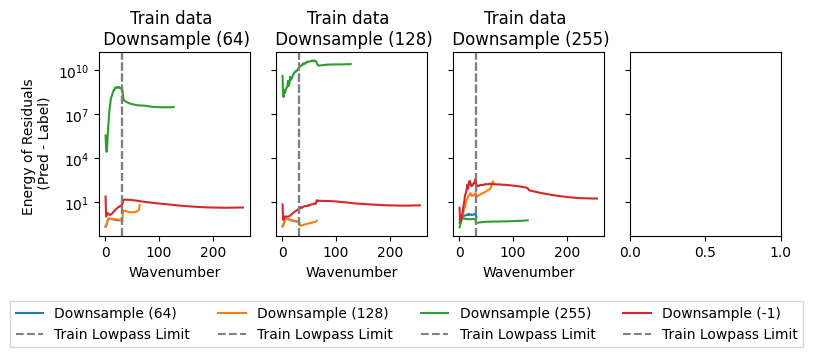

2d energy
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_16_8_64_FNO2D_1_1_05_1_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_32_8_64_FNO2D_1_1_05_1_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_rat

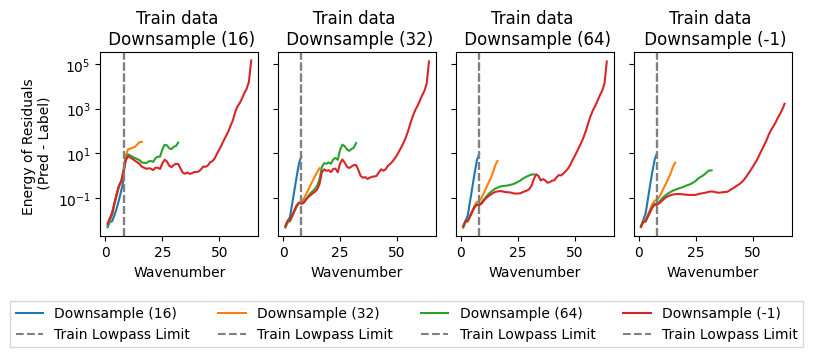

1d energy
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_64_burgers_pdebench_128_64_512_FNO1D_10_1_05_10_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_64_burgers_pdebench_256_64_512_FNO1D_10_1_05_10_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
re

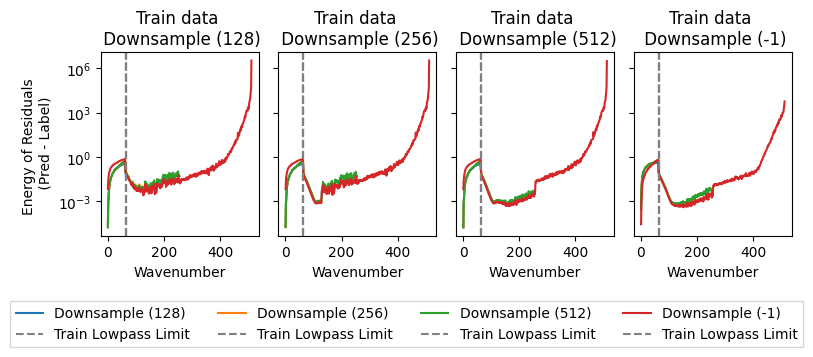

finished_exp=11, total_exp=12, 91.66666666666666 %


In [2]:
darcy_forcing_term = 1.0
burger_viscosity = 0.001
seed = 0
total_exp = 0
finished_exp = 0

for dataset_name in [
    'incomp_ns_pdebench',
    'darcy_pdebench',
    'burgers_pdebench',
    #'ns_pdebench',
]:
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
        
    if dataset_name == 'darcy_pdebench':
        img_size = 128
        fixed_lim = 8
        filter_lims = [8, 16, 32, -1]  # -1 finished
        downsample_dims = [16, 32, 64, -1]  # 16 finished

    if dataset_name == 'burgers_pdebench':
        img_size = 1024
        model_name = 'FNO1D'
        fixed_lim = 64
        filter_lims = [64, 128, 256, -1]  # -1 finished
        downsample_dims = [128, 256, 512, -1]  # 128 finished

    if dataset_name == 'incomp_ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 510
        fixed_lim = 32  # half of 64 // 2
        filter_lims = [8, 16, 32, -1]  # -1 finished
        downsample_dims = [64, 128, 255, -1]  # 85 finished
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'

    if dataset_name == 'ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 512
        fixed_lim = 32
        filter_lims = [16, 32, 64, -1]  # -1 finished
        downsample_dims = [64, 128, 256, -1]  # 64 finished

    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        lr,
        wd,
        pinn_loss_weight,
    ) = get_dataset_info(dataset_name, "mse")
    train_resolutions = [1,0,0,0]
    fig, axes = plt.subplots(
        nrows=1, ncols=4, sharey=True, sharex='col', figsize=(8, 3)
    )
    for epoch in [150]:  # 0, 50, 100, 250,
        for y_idx, max_mode in enumerate([64]):
            for x_idx, downsample_dim in enumerate(downsample_dims):
                for _y_idx, filter_lim in enumerate([fixed_lim]):
                    if filter_lim == -1 and downsample_dim != -1:
                        continue
                    max_mode = img_size // 2
                    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_{downsample_dim}_{filter_lim}_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
                    ckpt_dir = ckpt_dir.replace(".","")
                    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                    ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
                    total_exp += 1
                    if not os.path.exists(ckpt_file):
                        print(f'Does not exists: {ckpt_file}')
                        continue
                    finished_exp += 1
                    ckpt_name = f'{ckpt_pth}/train_stats.csv'
                    df = pd.read_csv(ckpt_name)
                    # load model
                    model = get_model(
                        model_name=model_name,
                        out_channels=out_channels,
                        in_channels=in_channels,
                        hidden_channels=32,
                        max_modes=max_mode,
                    ).to(device)
                    # ckpt_dict = load_latest_ckpt(ckpt_pth)
    
                    print(f'{ckpt_file=}')
                    ckpt_dict = torch.load(
                        ckpt_file,
                        weights_only=False,
                    )
                    model.load_state_dict(ckpt_dict['model_state_dict'])
    
                    # get data at various sizes
                    for test_down in downsample_dims:
                        dataset = get_dataset(
                            dataset_name=dataset_name,
                            filter_lim=filter_lim,
                            img_size='n/a',
                            downsample_dim=test_down,
                            train=False,
                            initial_steps=initial_steps,
                            model_name=model_name,
                            darcy_forcing_term=darcy_forcing_term,
                            burger_viscosity=burger_viscosity,
                            batch_size=batch_size,
                            seed=0,
                            resolution_ratios=train_resolutions,
                            loss_name="n/a",
                        )
                        test_loader = DataLoader(dataset, batch_size=1)
                        
                        dataset = get_dataset(
                            dataset_name=dataset_name,
                            filter_lim=-1,
                            img_size='n/a',
                            downsample_dim=test_down,
                            train=False,
                            initial_steps=initial_steps,
                            model_name=model_name,
                            darcy_forcing_term=darcy_forcing_term,
                            burger_viscosity=burger_viscosity,
                            batch_size=batch_size,
                            seed=0,
                            resolution_ratios=train_resolutions,
                            loss_name="n/a",
                        )
                        unfilter_test_loader = DataLoader(dataset, batch_size=1)
    
                        # get model preds
                        model_preds_test = get_model_preds(
                            test_loader, model, device, initial_steps
                        )
                        offset = 0
                        if initial_steps == 1:
                            offset = 1
                        labels = torch.concat(
                                [
                                    test_loader.dataset[i]['y'][:, initial_steps - offset:, ...]
                                    for i in range(len(test_loader))
                                ]
                            )
                        label_spectrum = energy_curve_func( labels)
                        unfilter_labels = torch.concat(
                            [
                                unfilter_test_loader.dataset[i]['y'][:, initial_steps - offset:, ...]
                                for i in range(len(unfilter_test_loader))
                            ]
                        )
                        residuals = (model_preds_test - labels.to(device))
                        unfilter_label_spectrum = energy_curve_func(
                            unfilter_labels
                        )
                        residual_spectrum = energy_curve_func(residuals)
    
                        x = np.linspace(
                            1, len(residual_spectrum), len(residual_spectrum)
                        )
                        axes[x_idx].set_yscale('log')
                        axes[x_idx].plot(
                            x,
                            residual_spectrum / unfilter_label_spectrum,
                            label=f'Downsample ({test_down})',
                        )
                        axes[x_idx].axvline(
                            x=filter_lim,
                            color='grey',
                            linestyle='--',
                            label='Train Lowpass Limit',
                        )
                        axes[x_idx].set_title(
                            f'Train data \n Downsample ({downsample_dim})'
                        )
                        axes[x_idx].set_xlabel('Wavenumber')
                        if x_idx == 0:
                            axes[x_idx].set_ylabel(
                                'Energy of Residuals \n (Pred - Label)'
                            )
                        handles, labels = axes[
                            x_idx
                        ].get_legend_handles_labels()
    
        fig.legend(
            handles=handles,
            labels=labels,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.0),
            fancybox=False,
            shadow=False,
            ncol=4,
        )
        plt.tight_layout()
        plt.show()
        # fig.savefig(
        #    f'{FIG_DIR}/varried_downsample_{epoch}_w_max_modes.png',
        #    dpi=300,
        #    bbox_inches='tight',
        # )
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp * 100} %')

# Multi-Res Training

Training curves w/ multi-res test sets

TODO: Plot multi-res spectrum

TODO: REDO ALL BURGERS DUE TO MULTI - RES data bug

Middle plot sweep:
- Story: Middle plot shows fragility
- Add in the residual energy spectrum for each res
- Add in the base energy spectrum for each res
- Add in 7:1:1:1 ratio, add in the 1:0:0:0 ratio

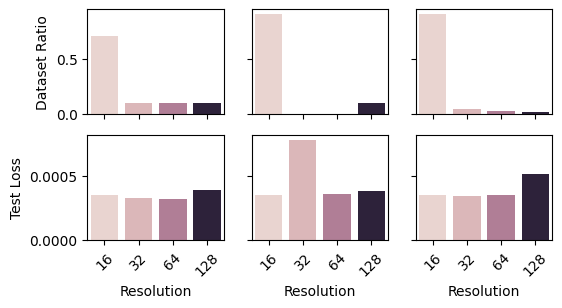

In [3]:
fig, axes = plt.subplots(
    nrows=2, ncols=3, sharey='row', sharex='col', figsize=(6, 3)
)

dataset_name = 'darcy_pdebench'
loss = 'mse'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, "mse")
#lr = str(lr).replace('.','')
if dataset_name == 'darcy_pdebench':
    img_sizes = [128, 64, 32, 16]
    img_size = 128
    max_mode = img_size // 2


final_ckpts = []

res_ratios = [
    [0.1,0.1,0.1,0.7],
    [0.1,0,0,0.9],
    [0.02,0.03,0.05,0.9],
]
for x_idx, res_ratio in enumerate(res_ratios):
    res_ratio_str = str_from_res(res_ratio)
    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{res_ratio_str}'
    ckpt_dir = ckpt_dir.replace('.','')
    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
    ckpt_name = f'{ckpt_pth}/train_stats.csv'

    if not os.path.exists(ckpt_name):
        print('does not exist: ', ckpt_dir)
        continue
    df = pd.read_csv(ckpt_name)
    losses = df[df.epoch==150][['test_res_0', 'test_res_1','test_res_2','test_res_3']].values.squeeze().tolist()
    sns.barplot(y=res_ratio, x=img_sizes, ax=axes[0, x_idx], hue=img_sizes)
    sns.barplot(y = losses, x=img_sizes,  ax=axes[1, x_idx], hue=img_sizes)
    axes[0, x_idx].get_legend().remove()
    axes[1, x_idx].get_legend().remove()
    axes[1, x_idx].tick_params(axis='x', labelrotation=45) 

    if x_idx == 0:
        axes[0, x_idx].set_ylabel('Dataset Ratio')
        axes[1, x_idx].set_ylabel('Test Loss')

    axes[1, x_idx].set_xlabel("Resolution")
#plt.legend(bbox_to_anchor=(-0.5, -0.5), loc='upper center', ncols=4)

DATASET:  burgers_pdebench


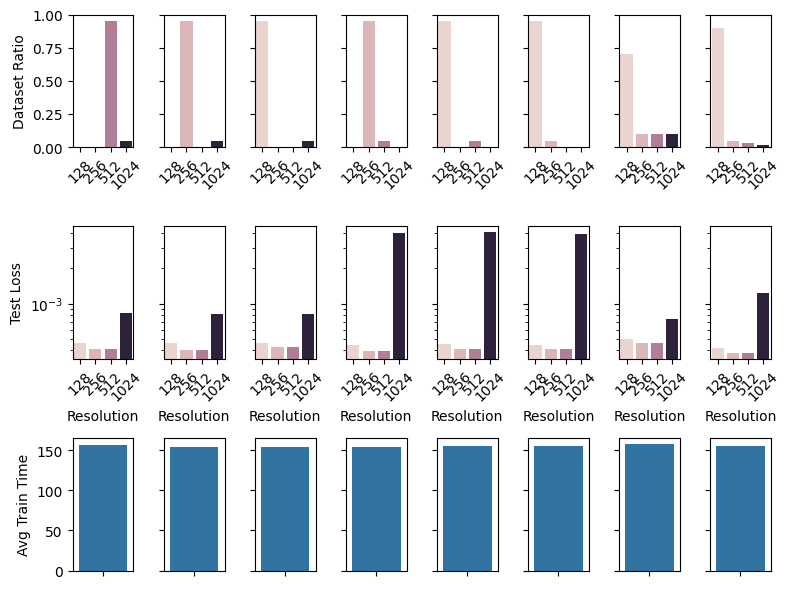

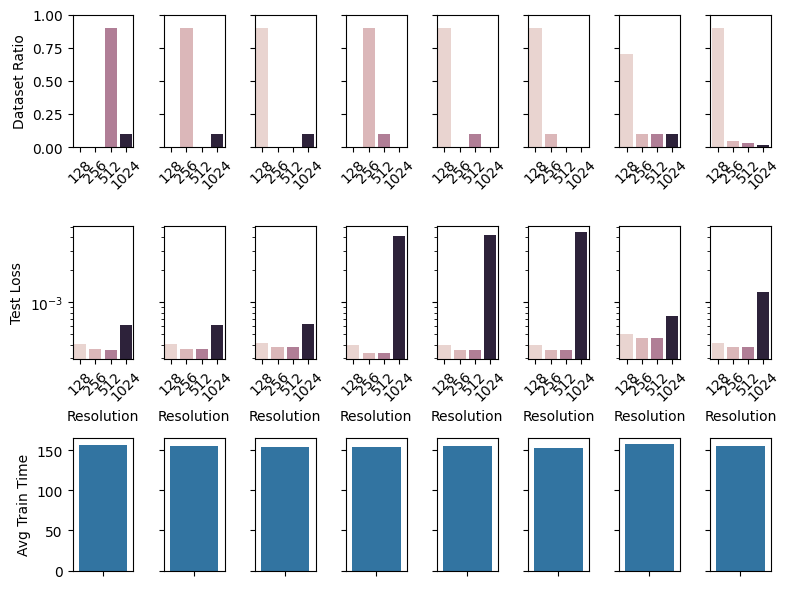

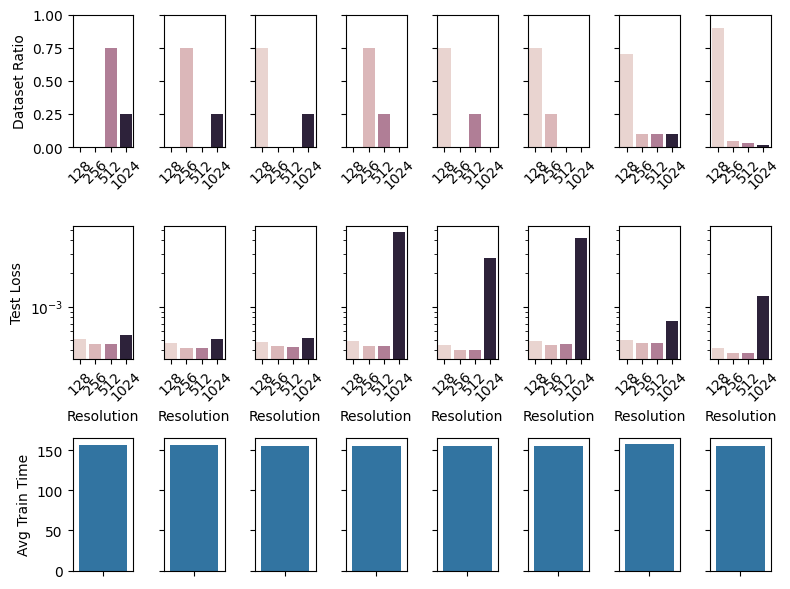

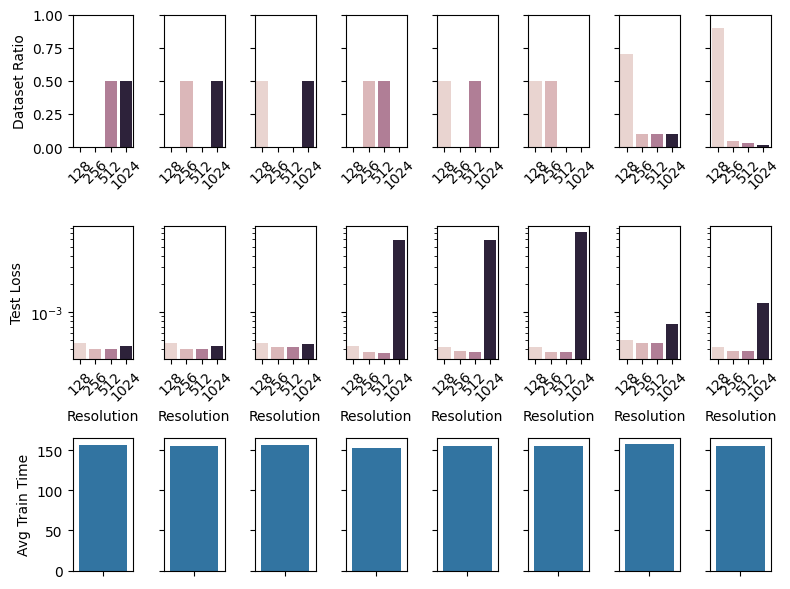

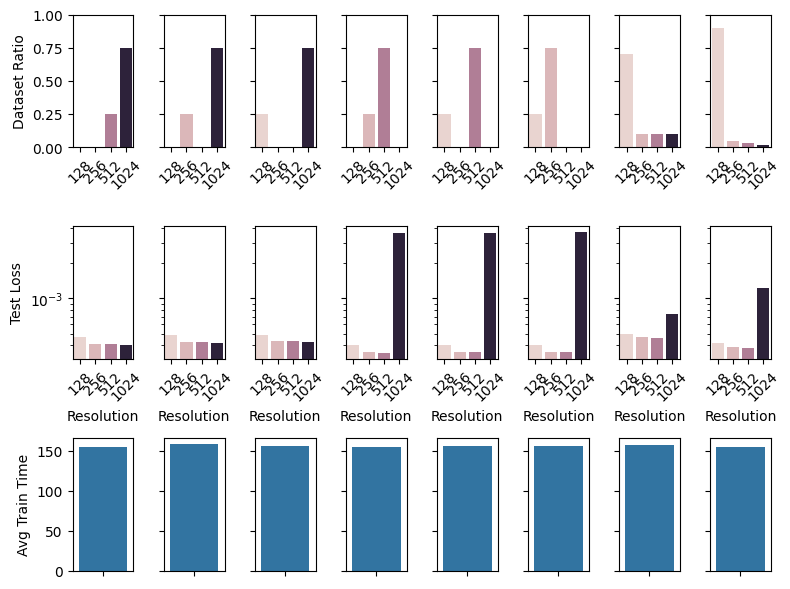

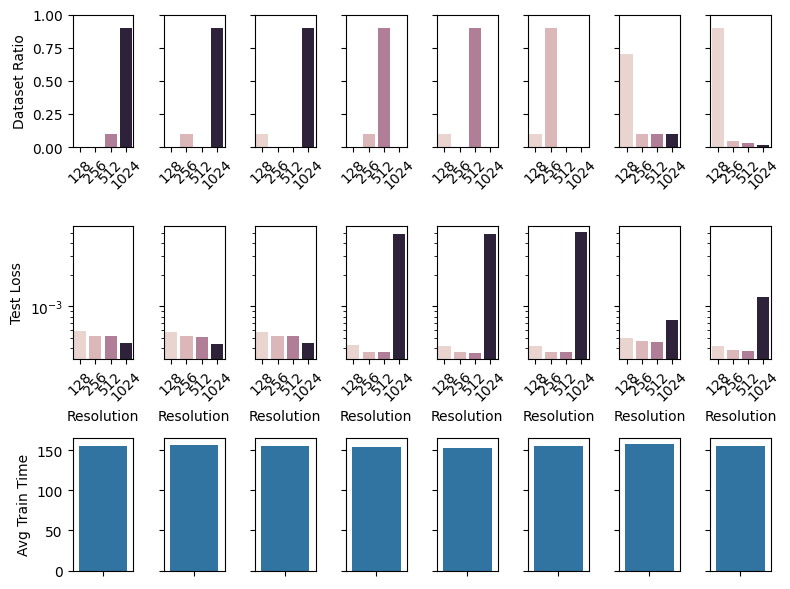

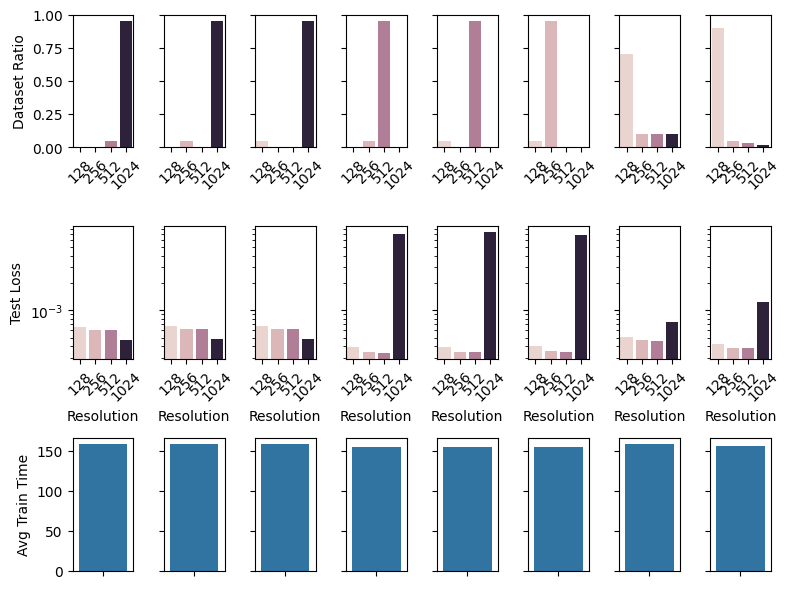

DATASET:  darcy_pdebench


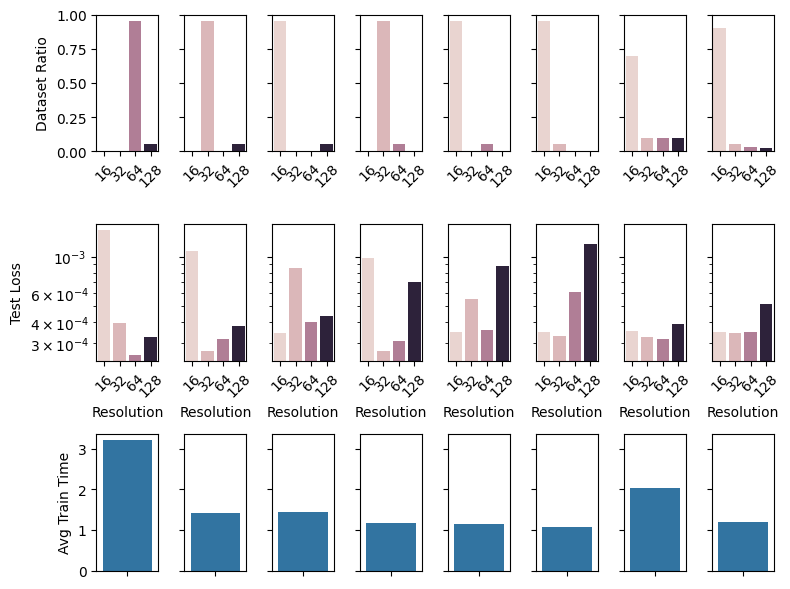

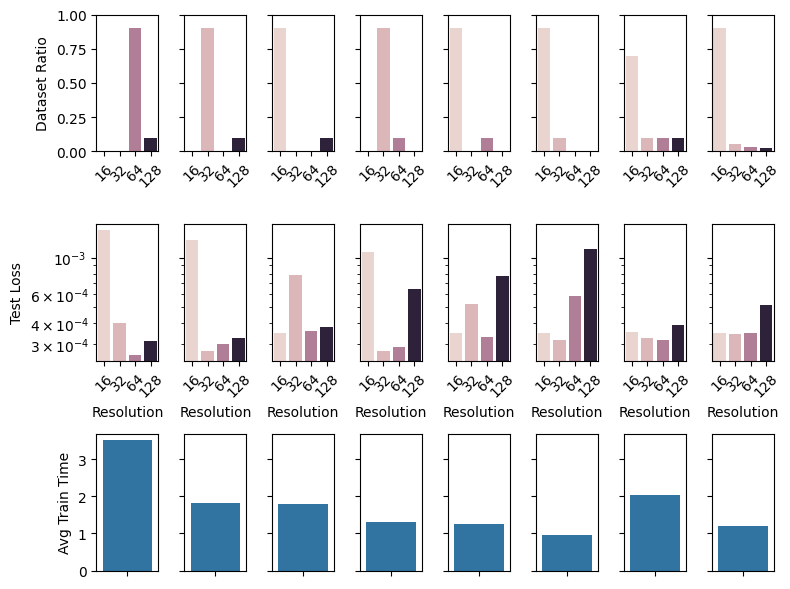

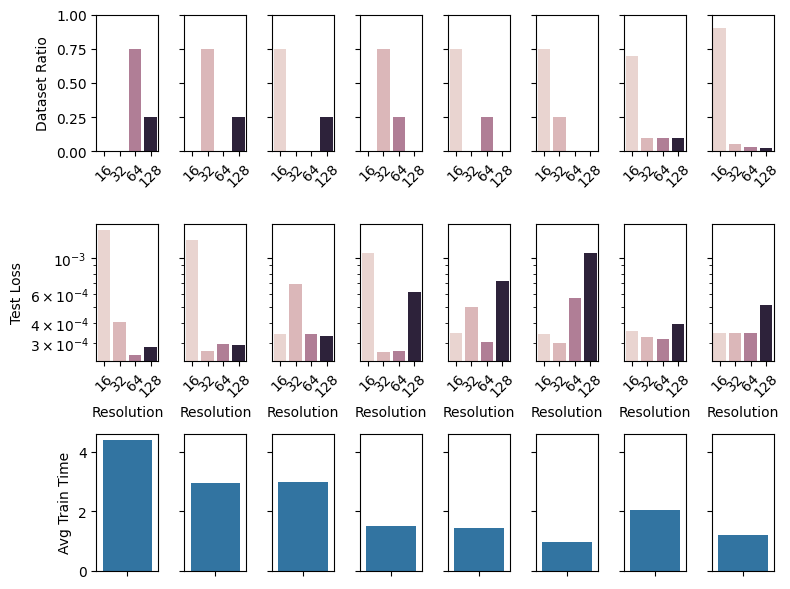

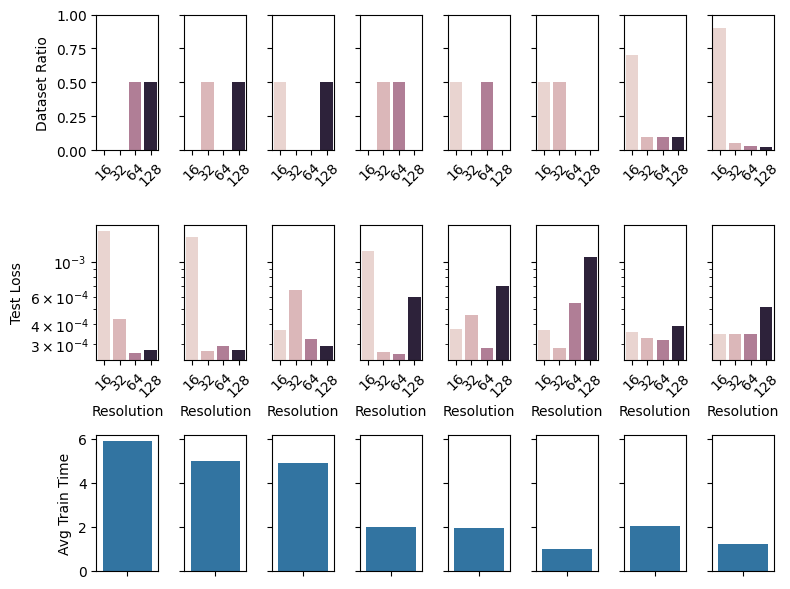

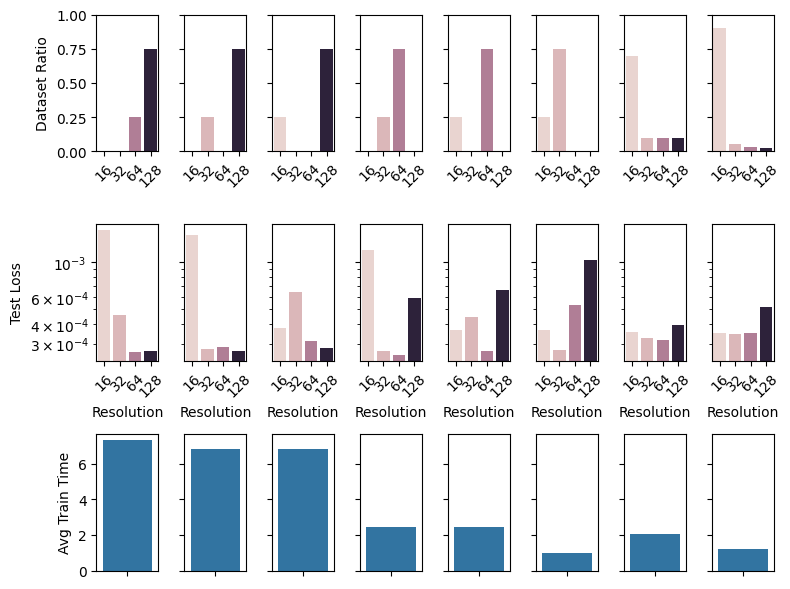

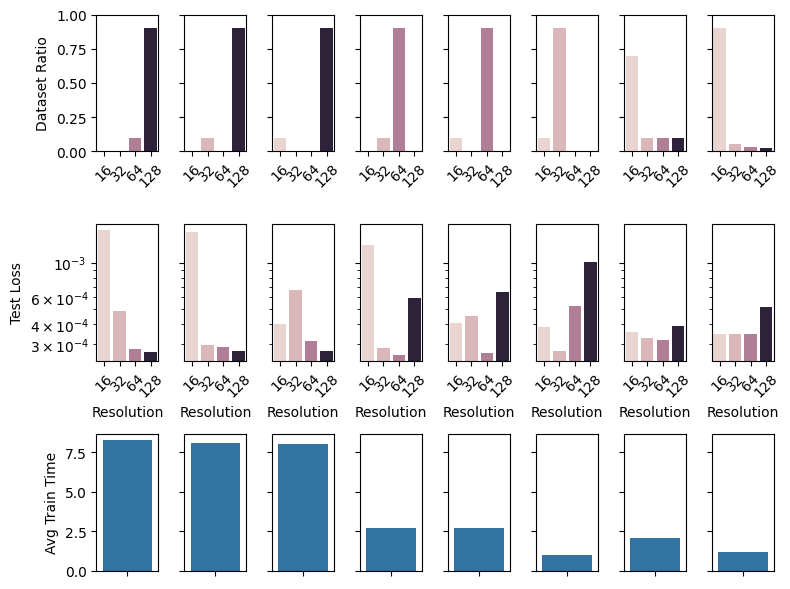

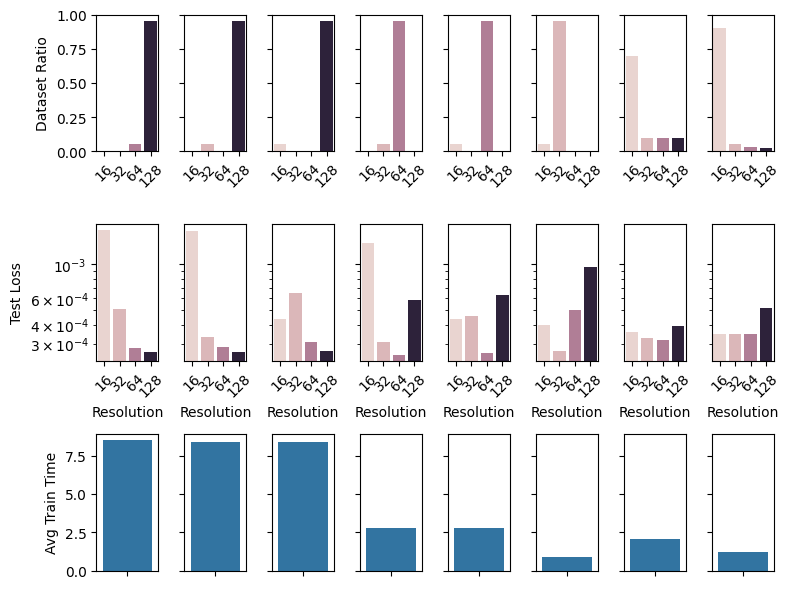

DATASET:  incomp_ns_pdebench


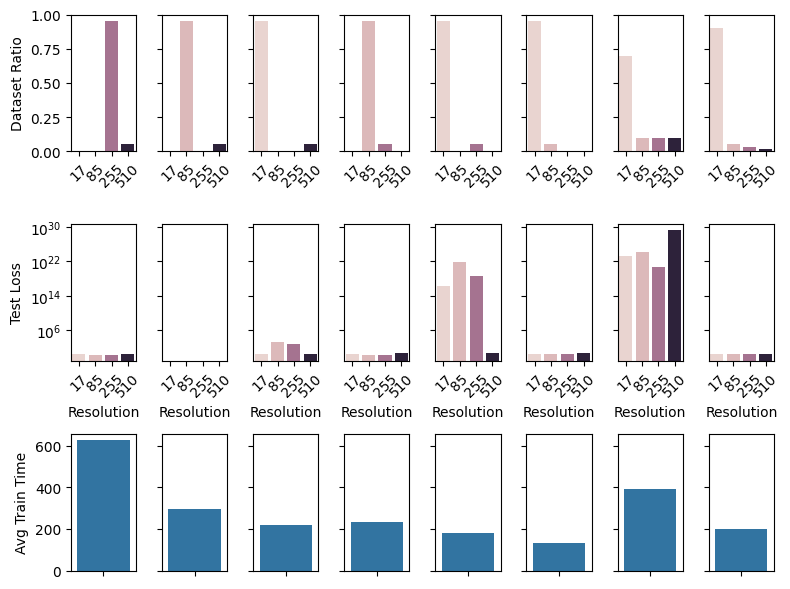

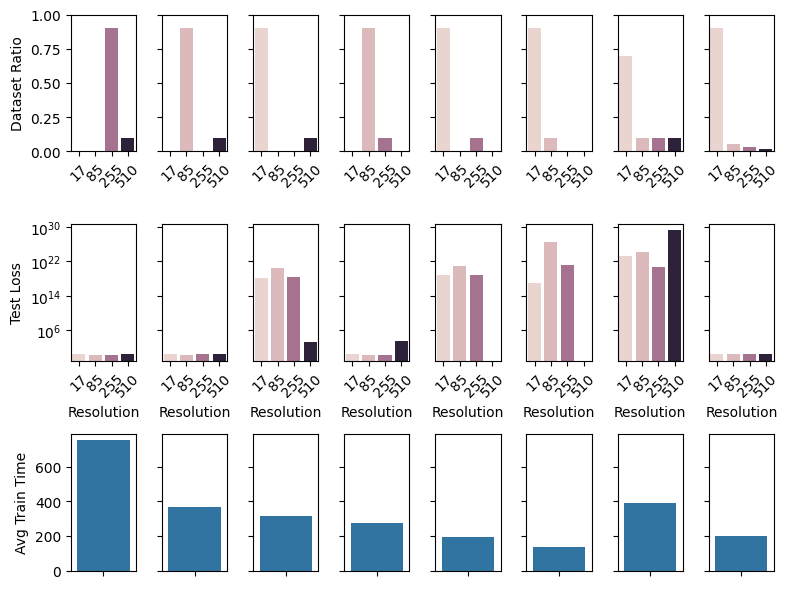

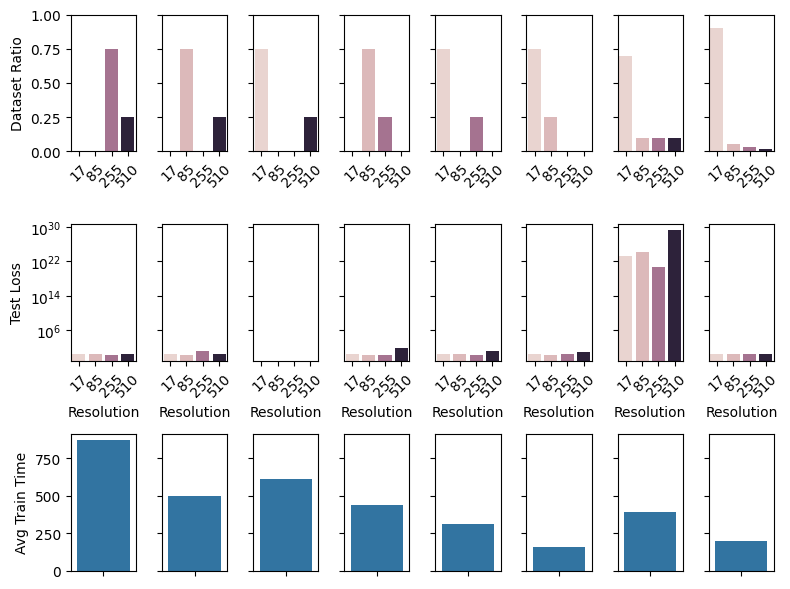

does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_05_05_0_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_05_0_05_0/


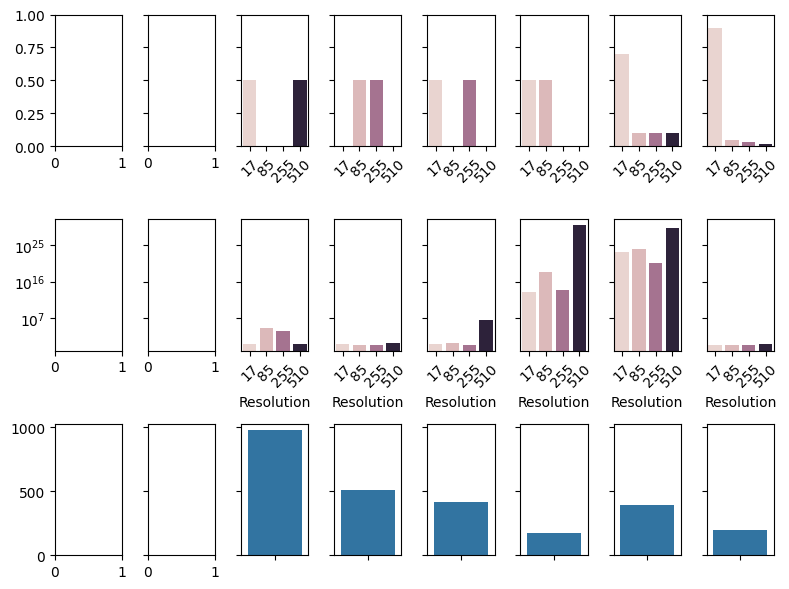

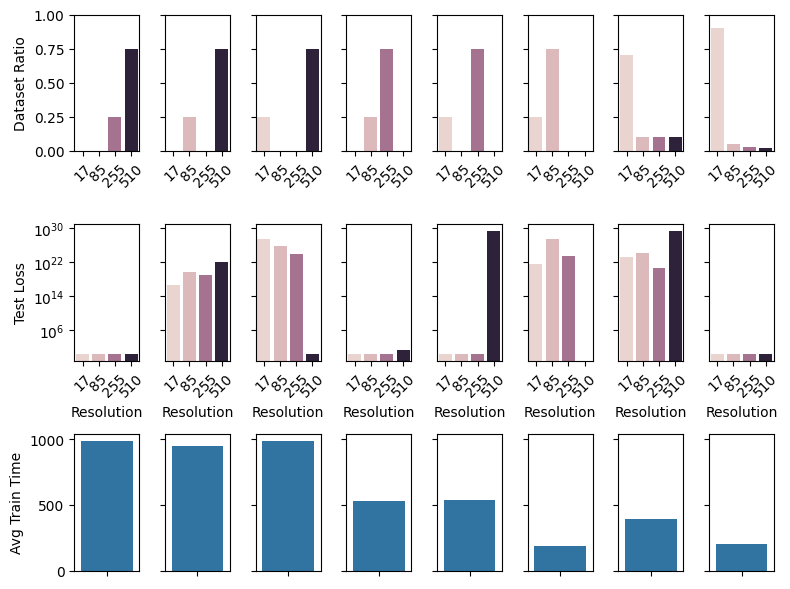

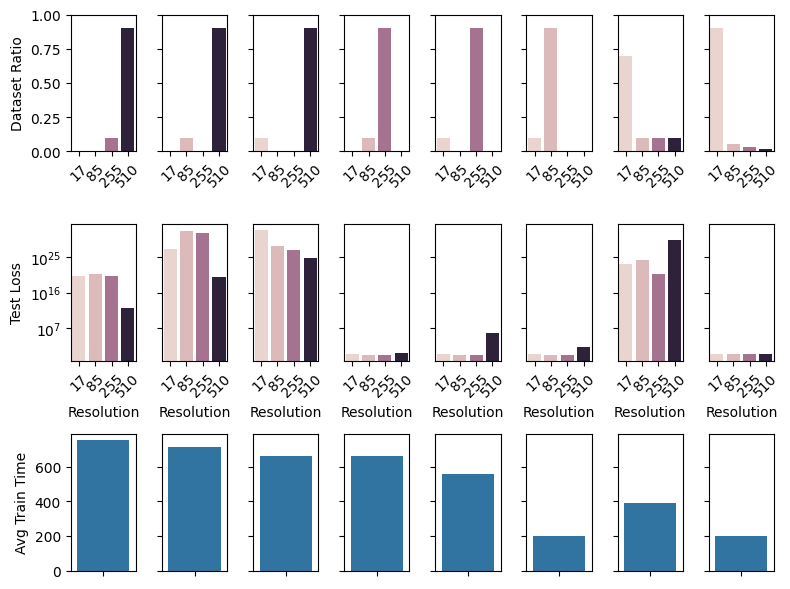

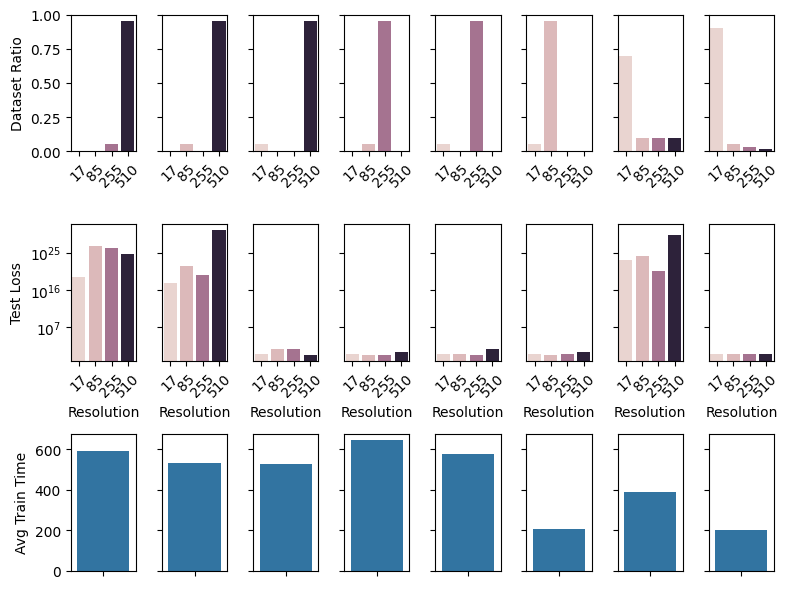

In [63]:
summary_stats = pd.DataFrame(columns=['test_loss', 'resolution', 'dataset', 'ratio', 'pair','avg_epoch_time'])

for dataset_name in ['burgers_pdebench','darcy_pdebench', 'incomp_ns_pdebench', ]: # , 'ns_pdebench'
    loss = 'mse'
    print("DATASET: ", dataset_name)
    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        lr,
        wd,
        pinn_loss_weight,
    ) = get_dataset_info(dataset_name, "mse")
    #lr = str(lr).replace('.','')
    ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    if dataset_name == 'darcy_pdebench':
        img_sizes = [128, 64, 32, 16]
        img_size = 128
    if dataset_name == 'burgers_pdebench':
        img_sizes = [1024, 512, 256, 128]
        img_size = 1024
    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [510, 255, 85, 17]
        img_size = 510
        #ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'
    if dataset_name == 'ns_pdebench':
        img_sizes = [512, 256, 128, 64]
        img_size = 512
        
    max_mode = img_size // 2
    
    
    final_ckpts = []
    
    res_ratios = [
        '[0.1,0.1,0.1,0.7]',
        '[0.1,0,0,0.9]',
        '[0.02,0.03,0.05,0.9]',
    ]
    for _idx, rat in enumerate([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]):
        fig, axes = plt.subplots(
            nrows=3, ncols=8, sharey='row', sharex=False, figsize=(8, 6)
        )
        for x_idx, (first_idx, second_idx) in enumerate([(0,1), (0,2), (0,3), (1,2), (1,3), (2,3), ('all',0), ('all_less', 0)]):
            if first_idx == "all":
                res_ratio = [0.1,0.1,0.1,0.7]
            elif first_idx == "all_less":
                res_ratio = [0.02,0.03,0.05,0.9]
            else:
                res_ratio = [0,0,0,0]
                res_ratio[first_idx] = rat
                res_ratio[second_idx] = round(1 - rat,2)
            res_ratio_str = str_from_res(res_ratio) 
            ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{res_ratio_str}'
            ckpt_dir = ckpt_dir.replace('.','')
            ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
            ckpt_name = f'{ckpt_pth}/train_stats.csv'
            ckpt_file = f'{ckpt_pth}/150_ckpt.pth'
        
            if not os.path.exists(ckpt_file):
                print('does not exist: ', ckpt_pth)
                continue
            df = pd.read_csv(ckpt_name)
            avg_per_epoch_train_time = df['train_time'].mean()
            losses = df[df.epoch==150][['test_res_0', 'test_res_1','test_res_2','test_res_3']].values.squeeze().tolist()
            for res, loss_val in enumerate(losses):
                summary_stats.loc[len(summary_stats)] = [loss_val, res, dataset_name, rat, (first_idx, second_idx),avg_per_epoch_train_time]
            sns.barplot(y=res_ratio, x=img_sizes, ax=axes[0, x_idx], hue=img_sizes)
            sns.barplot(y = losses, x=img_sizes,  ax=axes[1, x_idx], hue=img_sizes)
            axes[0, x_idx].get_legend().remove()
            axes[0,x_idx].set_ylim([0,1])
            axes[1, x_idx].get_legend().remove()
            axes[0, x_idx].tick_params(axis='x', labelrotation=45)
            axes[1, x_idx].tick_params(axis='x', labelrotation=45)
            axes[2, x_idx].tick_params(axis='x', labelrotation=45)
            axes[1, x_idx].set_yscale('log')

            
            sns.barplot(y=[avg_per_epoch_train_time,], x=["",], ax=axes[2,x_idx])
            #axes[2, x_idx].set_yscale('log')
            
            if x_idx == 0:
                axes[0, x_idx].set_ylabel('Dataset Ratio')
                axes[1, x_idx].set_ylabel('Test Loss')
                axes[2, x_idx].set_ylabel('Avg Train Time')
        
            axes[1, x_idx].set_xlabel("Resolution")

        plt.tight_layout()
        plt.show()

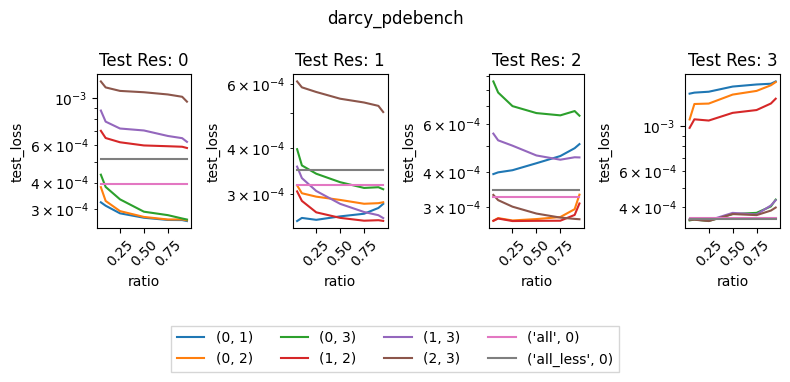

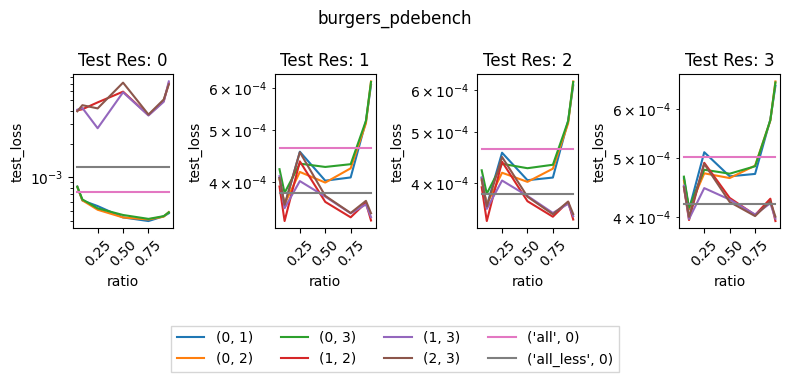

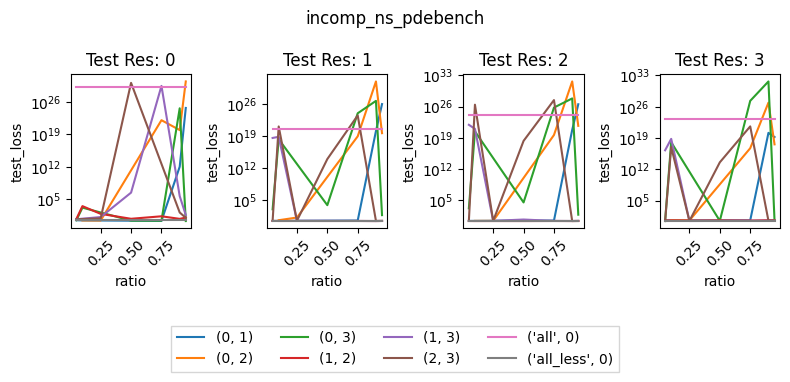

In [55]:
for dataset in ['darcy_pdebench', 'burgers_pdebench', 'incomp_ns_pdebench']:
    fig, axes = plt.subplots(
        nrows=1, ncols=4, sharey=False, sharex='col', figsize=(8, 3)
    )
    for res in range(4):
        for pair in summary_stats.pair.unique():
            sns.lineplot(x='ratio', y='test_loss', data=summary_stats[(summary_stats.resolution==res)&(summary_stats.pair==pair)&(summary_stats.dataset==dataset)], ax=axes[res], label=pair)
            axes[res].set_yscale('log')
            axes[res].set_title(f"Test Res: {res}")
            handles, labels = axes[
                            res
                        ].get_legend_handles_labels()
            axes[res].get_legend().remove()
            axes[res].tick_params(axis='x', labelrotation=45) 
    fig.legend(
                handles=handles,
                labels=labels,
                loc='upper center',
                bbox_to_anchor=(0.5, -0.05),
                fancybox=False,
                shadow=False,
                ncol=4,
            )
    plt.suptitle(dataset)
    plt.tight_layout()
    plt.show()

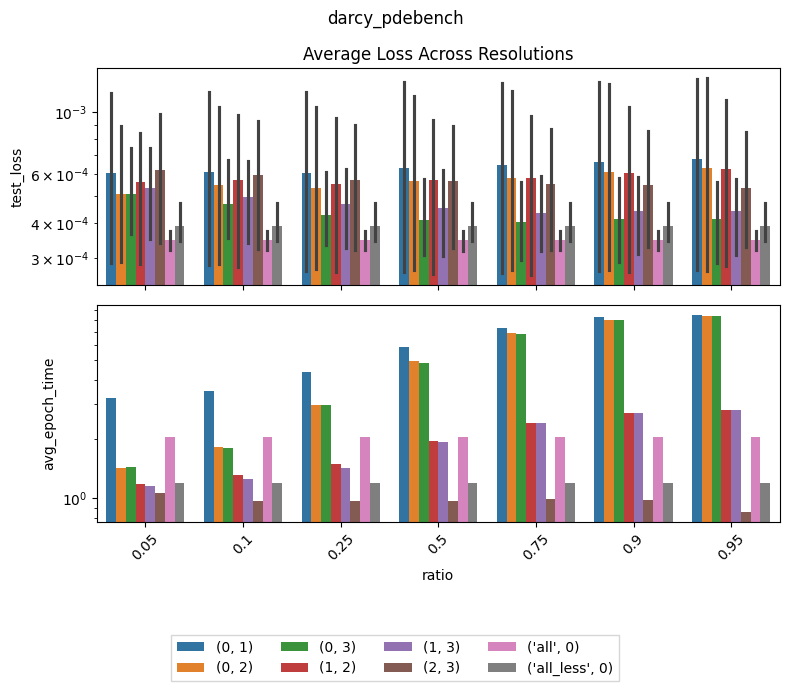

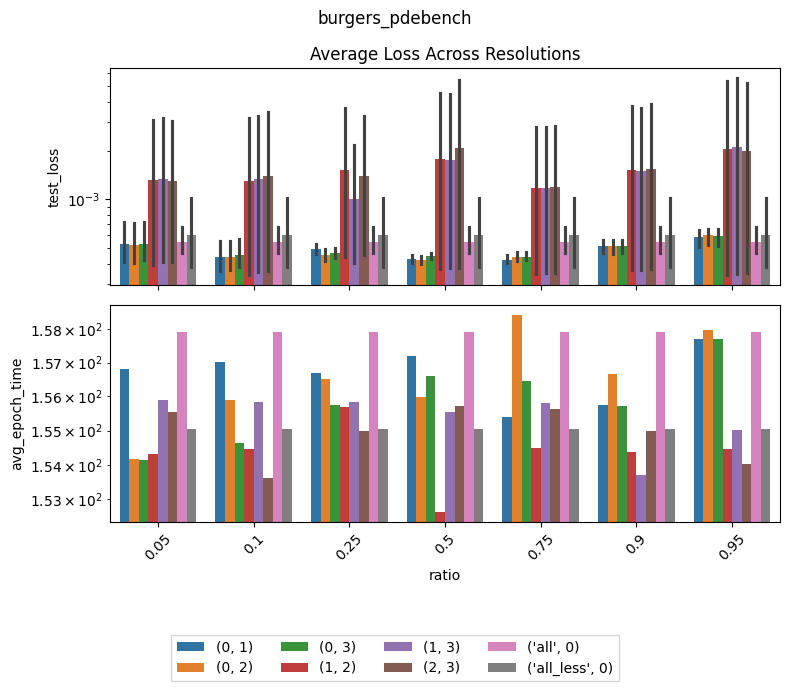

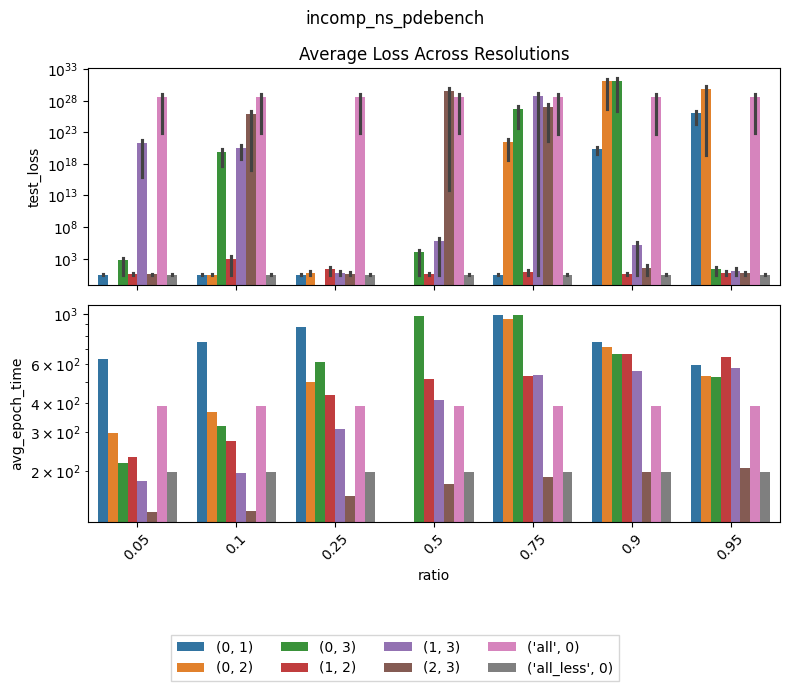

In [66]:
for dataset in ['darcy_pdebench', 'burgers_pdebench', 'incomp_ns_pdebench']:
    fig, axes = plt.subplots(
        nrows=2, ncols=1, sharey=False, sharex='col', figsize=(8, 6)
    )
    #for res in range(4):
    #for idx, pair in enumerate(summary_stats.pair.unique()):
    sns.barplot(x='ratio', y='test_loss', data=summary_stats[(summary_stats.dataset==dataset)], ax=axes[0], hue="pair")
    axes[0].set_yscale('log')

    sns.barplot(x='ratio', y='avg_epoch_time', data=summary_stats[(summary_stats.dataset==dataset)], ax=axes[1], hue="pair")
    axes[1].set_yscale('log')
    
    axes[0].set_title(f"Average Loss Across Resolutions")
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    axes[1].tick_params(axis='x', labelrotation=45) 
    fig.legend(
                handles=handles,
                labels=labels,
                loc='upper center',
                bbox_to_anchor=(0.5, -0.05),
                fancybox=False,
                shadow=False,
                ncol=4,
            )
    plt.suptitle(dataset)
    plt.tight_layout()
    plt.show()

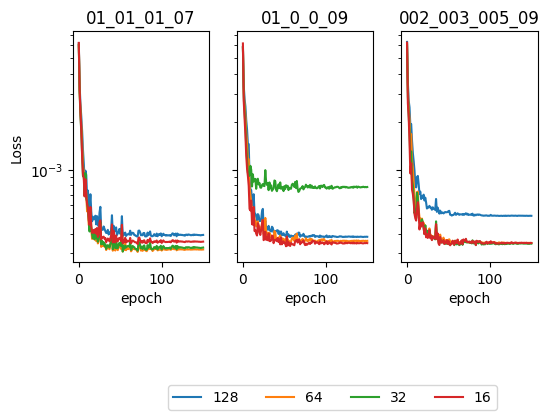

In [17]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, sharey=True, sharex='col', figsize=(6, 3)
)

dataset_name = 'darcy_pdebench'
loss = 'mse'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, "mse")
#lr = str(lr).replace('.','')
if dataset_name == 'darcy_pdebench':
    img_sizes = [128, 64, 32, 16]
    img_size = 128
    max_mode = img_size // 2


final_ckpts = []

res_ratios = [
    [0.1,0.1,0.1,0.7],
    [0.1,0,0,0.9],
    [0.02,0.03,0.05,0.9],
]
for x_idx, res_ratio in enumerate(res_ratios):
    res_ratio = str_from_res(res_ratio)
    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{res_ratio}'
    ckpt_dir = ckpt_dir.replace('.','')
    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
    ckpt_name = f'{ckpt_pth}/train_stats.csv'

    if not os.path.exists(ckpt_name):
        print('does not exist: ', ckpt_dir)
        continue
    df = pd.read_csv(ckpt_name)
    df['res_ratio'] = res_ratio
    final_ckpts.append(df[df.epoch == 150])
    for res in range(4):
        ylabel = f'test_res_{res}'
        sns.lineplot(
            df,
            x='epoch',
            y=ylabel,
            label=f'{img_sizes[res]}',
            ax=axes[x_idx],
        )
        axes[x_idx].get_legend().remove()
        axes[x_idx].set_yscale('log')
        axes[x_idx].set_title(res_ratio)
        axes[x_idx].set_ylabel('Loss')

plt.legend(bbox_to_anchor=(-0.5, -0.5), loc='upper center', ncols=4)

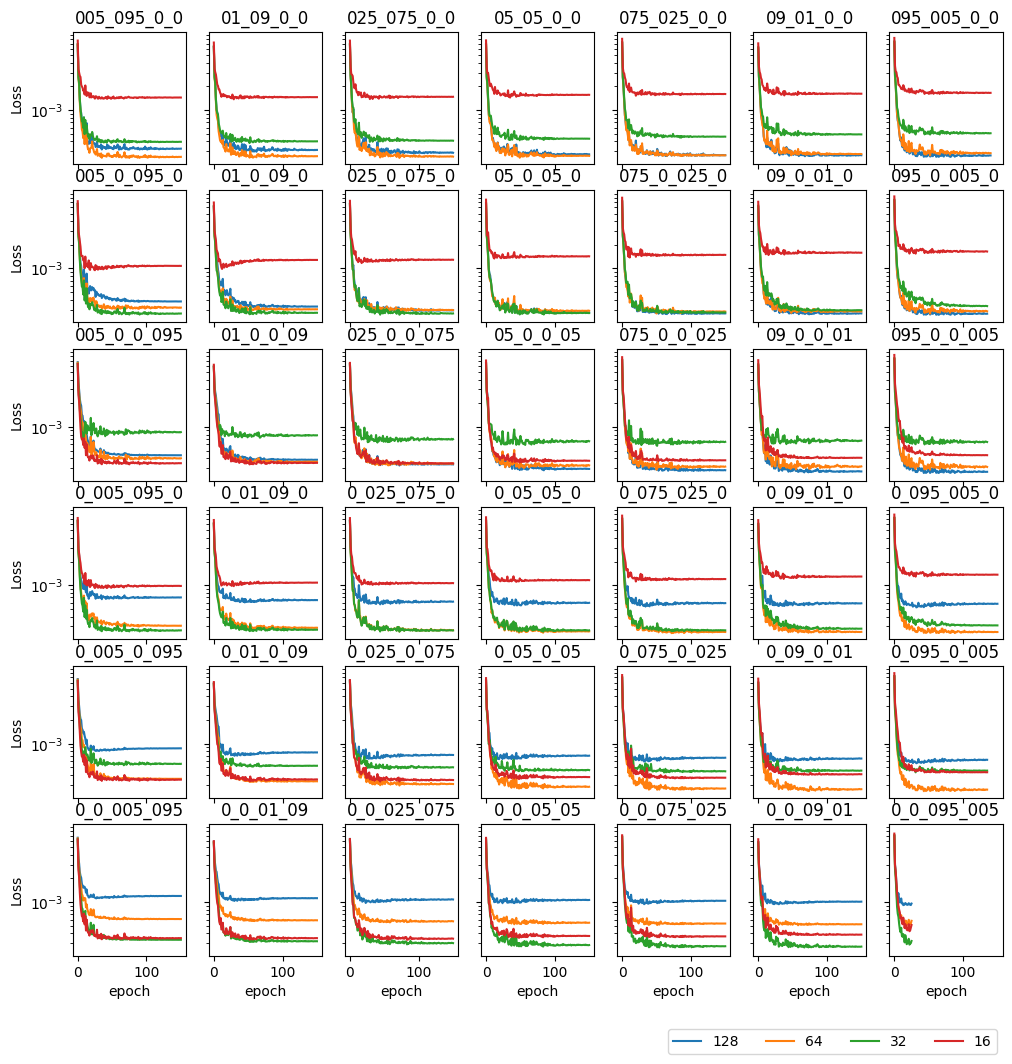

In [72]:
fig, axes = plt.subplots(
    nrows=6, ncols=7, sharey=True, sharex='col', figsize=(12, 12)
)

dataset_name = 'darcy_pdebench'
loss = 'mse'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, "mse")
#lr = str(lr).replace('.','')
if dataset_name == 'darcy_pdebench':
    img_sizes = [128, 64, 32, 16]
    img_size = 128
    max_mode = img_size // 2


final_ckpts = []

res_ratios = [
    '[0.1,0.1,0.1,0.7]',
    '[0.1,0,0,0.9]',
    '[0.02,0.03,0.05,0.9]',
]
for x_idx, rat in enumerate([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]):
    for y_idx, (first_idx, second_idx) in enumerate([(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]):
        ratio = [0,0,0,0]
        ratio[first_idx] = rat
        ratio[second_idx] = round(1 - rat,2)
        res_ratio = str_from_res(ratio) #str(ratio).replace(" ","")
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{res_ratio}'
        ckpt_dir = ckpt_dir.replace('.','')
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        ckpt_name = f'{ckpt_pth}/train_stats.csv'
    
        if not os.path.exists(ckpt_name):
            print('does not exist: ', ckpt_dir)
            continue
        df = pd.read_csv(ckpt_name)
        df['res_ratio'] = res_ratio
        final_ckpts.append(df[df.epoch == 150])
        for res in range(4):
            ylabel = f'test_res_{res}'
            sns.lineplot(
                df,
                x='epoch',
                y=ylabel,
                label=f'{img_sizes[res]}',
                ax=axes[y_idx, x_idx],
            )
            axes[y_idx, x_idx].get_legend().remove()
            axes[y_idx, x_idx].set_yscale('log')
            axes[y_idx, x_idx].set_title(res_ratio)
            axes[y_idx, x_idx].set_ylabel('Loss')

plt.legend(bbox_to_anchor=(-0.5, -0.5), loc='upper center', ncols=4)

In [15]:
final_ckpt = pd.concat(final_ckpts)
final_ckpt['avg'] = final_ckpt[
    ['test_res_0', 'test_res_1', 'test_res_2', 'test_res_3']
].mean(axis=1)
final_ckpt

epoch  train_loss  train_time  test_res_0  test_res_1  test_res_2  \
150    150    0.000288    1.670186    0.000392    0.000318    0.000327   
150    150    0.000285    1.745384    0.000381    0.000360    0.000781   
150    150    0.000286    0.912009    0.000516    0.000349    0.000346   

     test_res_3         res_ratio       avg  
150    0.000356     [01,01,01,07]  0.000348  
150    0.000348       [01,0,0,09]  0.000468  
150    0.000349  [002,003,005,09]  0.000390

# Generalization Across Turbulence Scales

NS trained at low turbulence, evaluated at high-turbulence

# OLD FIGS

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


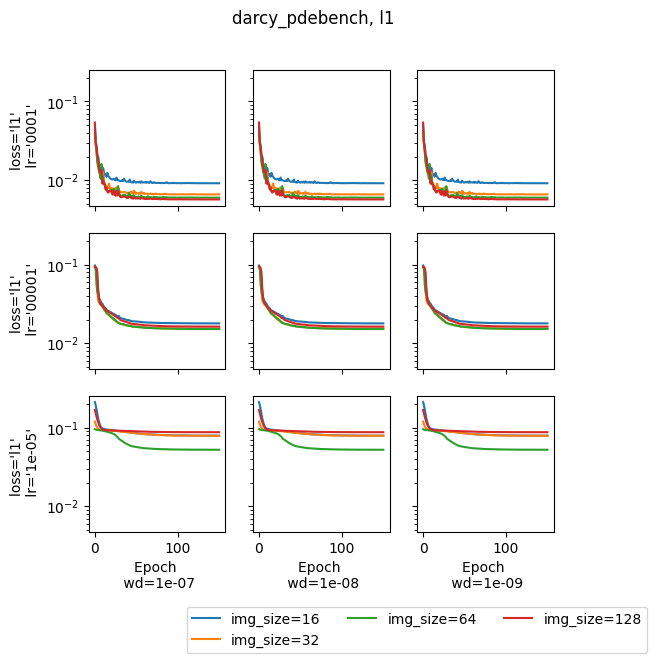

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


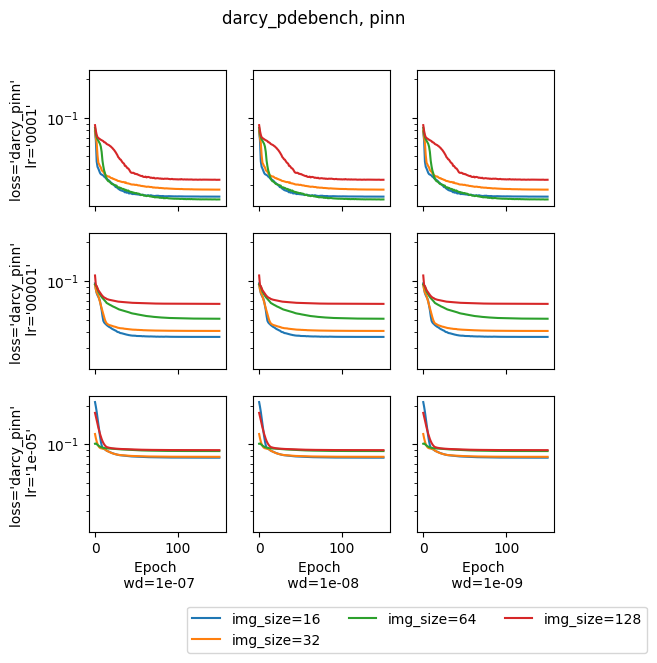

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


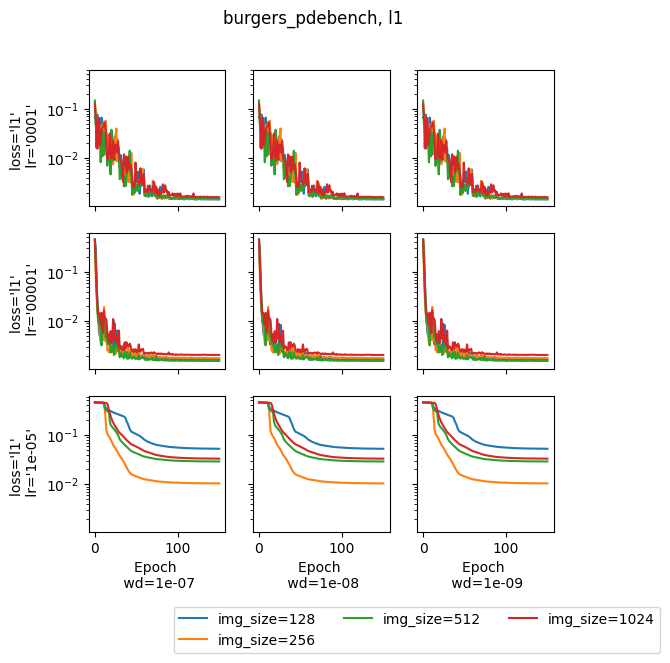

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


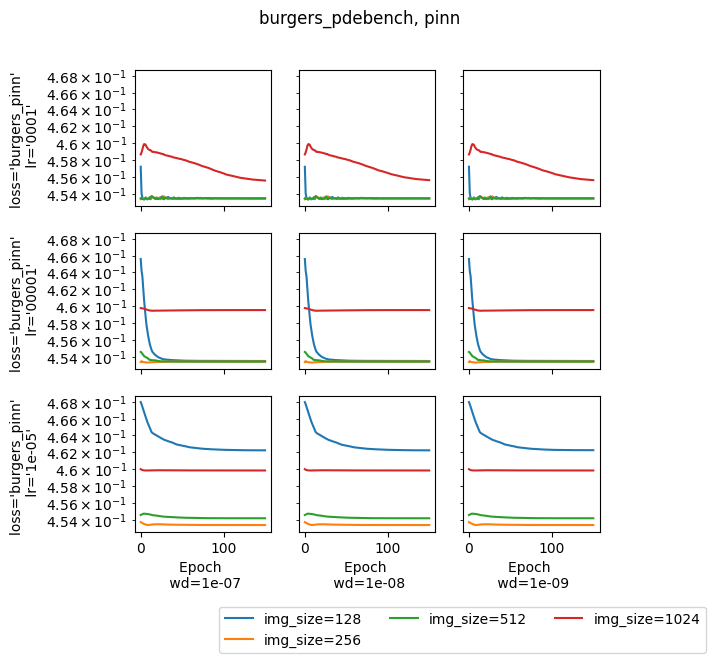

does not exist:  0001_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-08_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-09_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-08_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-09_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-08_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-09_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10


/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


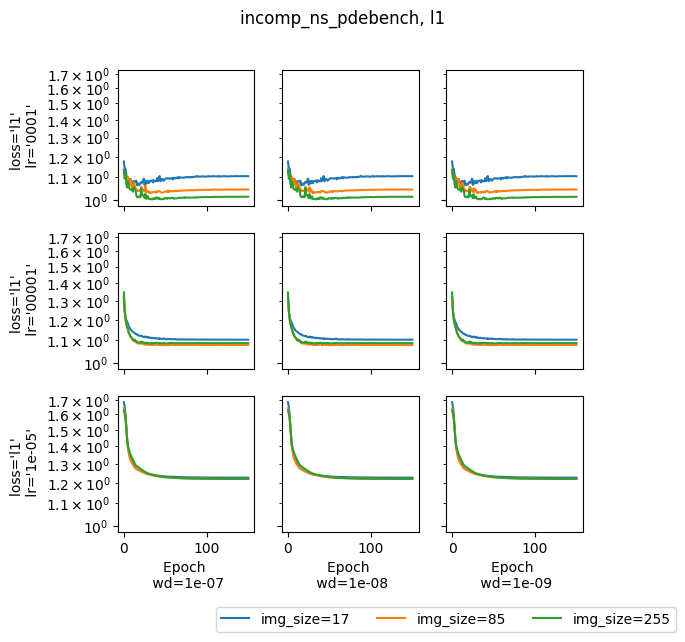

does not exist:  0001_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-09_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-09_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-09_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10


/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


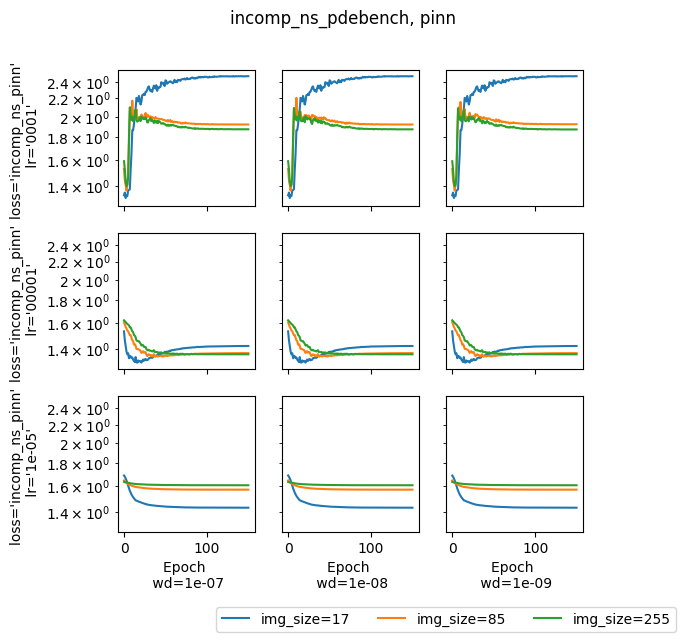

finished_exp=198, total_exp=216, 0.9166666666666666 %


In [3]:
# Check if all experiments have finished
total_exp = 0
finished_exp = 0
for dataset_name in [
    'darcy_pdebench',
    'burgers_pdebench',
    'incomp_ns_pdebench',
]:
    model_name = 'FNO2D'
    in_channels = 10
    initial_steps = 10

    if dataset_name == 'darcy_pdebench':
        img_sizes = [16, 32, 64, 128]
        pinn_loss_name = 'darcy_pinn'
        batch_size = 128
        in_channels = 1
        initial_steps = 1

    if dataset_name == 'burgers_pdebench':
        img_sizes = [128, 256, 512, 1024]
        pinn_loss_name = 'burgers_pinn'
        batch_size = 64
        model_name = 'FNO1D'

    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [17, 85, 255, 510]
        pinn_loss_name = 'incomp_ns_pinn'
        batch_size = 4

    for loss_type in ['l1', 'pinn']:
        loss = 'l1'
        if loss_type == 'pinn':
            loss = pinn_loss_name
        fig, axes = plt.subplots(
            nrows=3, ncols=3, sharey=True, sharex='col', figsize=(6, 6)
        )
        for y_idx, lr in enumerate(['0001', '00001', '1e-05']):
            for x_idx, wd in enumerate([1e-07, 1e-08, 1e-09]):
                for color_idx, img_size in enumerate(img_sizes):
                    max_mode = img_size // 2
                    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{img_size}_{max_mode}_{model_name}_{in_channels}_{initial_steps}'
                    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                    ckpt_name = f'{ckpt_pth}/train_stats.csv'
                    total_exp += 1
                    if not os.path.exists(ckpt_name):
                        print('does not exist: ', ckpt_dir)
                        continue
                    df = pd.read_csv(ckpt_name)
                    for ylabel in [
                        #'train_loss',
                        'test',
                    ]:
                        if 150 in df['epoch']:
                            finished_exp += 1
                        sns.lineplot(
                            df,
                            x='epoch',
                            y=ylabel,
                            label=f'{img_size=}',
                            ax=axes[y_idx, x_idx],
                        )
                        axes[y_idx, x_idx].get_legend().remove()
                        axes[y_idx, x_idx].set_yscale('log')

                if y_idx == 2:
                    axes[y_idx, x_idx].set_xlabel(f'Epoch \n {wd=}')
                if x_idx == 0:
                    axes[y_idx, x_idx].set_ylabel(f'{loss=} \n {lr=}')

        plt.legend(bbox_to_anchor=(0, -0.5), loc='upper center', ncols=3)
        plt.tight_layout()
        fig.suptitle(f'{dataset_name}, {loss_type}')
        plt.show()
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp} %')

# (BE CAREFUL W/ this is could override things) Recover stats

In [19]:
from operator_aliasing.train.train import test_model


def recompute_train_test_stats(
    dataset_name,
    filter_lim,
    downsample_dim,
    initial_steps,
    model_name,
    seed,
    batch_size,
    train_resolutions,
    in_channels,
    out_channels,
    max_mode,
    pinn_loss_weight,
):
    stats = pd.DataFrame(columns=['epoch', 'train_loss', 'test', 'train_time'])
    darcy_forcing_term = 1.0
    burger_viscosity = 0.001
    # load relavent dataset
    train_loader, test_loaders = get_data(
        dataset_name=dataset_name,
        filter_lim=filter_lim,
        img_size='n/a',
        downsample_dim=downsample_dim,
        train=True,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
        seed=seed,
        batch_size=batch_size,
        resolution_ratios=eval(train_resolutions),
        test_res='single',
    )

    # train_resolutions =
    # iterate thought all ckpts
    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{train_resolutions}'
    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
    model = get_model(
        model_name=model_name,
        max_modes=max_mode,
        hidden_channels=32,
        in_channels=in_channels,
        out_channels=out_channels,
    ).to(device)

    print(ckpt_dir)
    for epoch in range(0, 155, 5):
        ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
        if not os.path.exists(ckpt_file):
            return
        ckpt_dict = torch.load(
            ckpt_file,
            weights_only=False,
        )
        model.load_state_dict(ckpt_dict['model_state_dict'])
        model = model.to(device)
        model = model.eval()

        # compute train/test loss
        train_loss = test_model(
            model,
            {'train': train_loader},
            device,
            initial_steps,
        )
        test_loss = test_model(
            model,
            test_loaders,
            device,
            initial_steps,
        )

        stats.loc[len(stats)] = [
            epoch,
            train_loss['train'],
            test_loss['test'],
            None,
        ]

    print(stats)
    stats.to_csv(f'{ckpt_pth}/train_stats.csv', index=False)
    return

In [8]:
# Check if all experiments have finished
total_exp = 0
finished_exp = 0
seed = 0
learning_rates = {'001': 1e-2, '0001': 1e-3, '00001': 1e-4, '1e-05': 1e-5}
pinn_weights = {'05': 0.5, '025': 0.25, '01': 0.1}
summary_stats = pd.DataFrame(
    columns=['data', 'loss', 'lr', 'wd', 'pinn_loss_weight', 'test']
)
for dataset_name in [
    #'darcy_pdebench',
    'burgers_pdebench',
    #'incomp_ns_pdebench',
    #'ns_pdebench',
]:
    model_name = 'FNO2D'
    in_channels = 10
    out_channels = 1
    initial_steps = 10
    # if dataset_name == 'incomp_ns_pdebench':

    # incomp_ns args
    img_size = 255
    pinn_loss_name = 'incomp_ns_pinn'
    batch_size = 4

    if dataset_name == 'ns_pdebench':
        img_size = 256
        pinn_loss_name = 'n/a'
        batch_size = 4
        # num time steps * channels:
        in_channels = 40
        # num channels:
        out_channels = 4

    if dataset_name == 'darcy_pdebench':
        img_size = 64
        pinn_loss_name = 'darcy_pinn'
        batch_size = 128
        in_channels = 1
        initial_steps = 1

    if dataset_name == 'burgers_pdebench':
        img_size = 512
        pinn_loss_name = 'burgers_pinn'
        batch_size = 64
        model_name = 'FNO1D'

    for loss_type in ['mse', 'pinn']:
        loss = loss_type
        if loss_type == 'pinn':
            loss = pinn_loss_name
        if loss == 'n/a':
            continue
        for y_idx, lr in enumerate(['001', '0001', '00001', '1e-05']):
            for x_idx, wd in enumerate([1e-05, 1e-06, 1e-07]):
                pinn_loss_weights = ['05']
                if 'pinn' in loss_type:
                    pinn_loss_weights += ['025', '01']
                for pinn_loss_weight in pinn_loss_weights:
                    max_mode = img_size // 2

                # recompute_train_test_stats(dataset_name, -1, -1, initial_steps, model_name, seed, batch_size, '[0,1,0,0]', in_channels, out_channels, max_mode, pinn_loss_weight)